In [1]:
# ---------------------------
# Step 1: Setup
# ---------------------------

# Import required libraries
import torch
import sentencepiece as spm
import numpy as np
import pandas as pd
import random
import os

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Detect device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [2]:

# ---------------------------
# Step 2: Dataset Import + Normalization
# ---------------------------

# Clone repo and unzip dataset
!git clone https://github.com/amir9ume/urdu_ghazals_rekhta.git
!unzip -q /kaggle/working/urdu_ghazals_rekhta/dataset/dataset.zip -d /kaggle/working/urdu_ghazals_rekhta/dataset

import os
import unicodedata
import re
from itertools import zip_longest

# Dataset path (Kaggle)
BASE_DIR = "/kaggle/working/urdu_ghazals_rekhta/dataset/dataset"

# Output normalized corpus files
SRC_FILE = "/kaggle/working/urdu.txt"    # Urdu side
TGT_FILE = "/kaggle/working/roman.txt"   # Roman/English side

# --- Normalization functions ---
def is_letter(ch):
    return ch.isalpha()

def remove_inner_dots(s: str) -> str:
    if not s:
        return s
    out = []
    L = len(s)
    for i, ch in enumerate(s):
        if ch == '.':
            prev_is_letter = (i - 1 >= 0 and is_letter(s[i-1]))
            next_is_letter = (i + 1 < L and is_letter(s[i+1]))
            if prev_is_letter and next_is_letter:
                continue
            else:
                out.append(ch)
        else:
            out.append(ch)
    return "".join(out)

def normalize_english(text: str) -> str:
    if not text:
        return ""
    text = text.lower()
    text = unicodedata.normalize("NFKD", text)
    text = text.encode("ascii", "ignore").decode("ascii")
    text = remove_inner_dots(text)
    text = re.sub(r"[‘’'\"`]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def normalize_urdu(text: str) -> str:
    if not text:
        return ""
    text = unicodedata.normalize("NFC", text)
    cleaned_chars = []
    for c in text:
        cp = ord(c)
        if (0xFB50 <= cp <= 0xFDFF) or (0xFE70 <= cp <= 0xFEFF):
            continue
        cleaned_chars.append(c)
    text = "".join(cleaned_chars)
    text = text.replace("ؔ", "")
    text = remove_inner_dots(text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# --- File processor ---
def process_pair_files(en_file_path, ur_file_path, src_out, tgt_out):
    with open(en_file_path, "r", encoding="utf-8", errors="replace") as enf, \
         open(ur_file_path, "r", encoding="utf-8", errors="replace") as urf:
        for en_line, ur_line in zip_longest(enf, urf, fillvalue=""):
            en_line = en_line.strip()
            ur_line = ur_line.strip()
            if en_line and ur_line:
                en_norm = normalize_english(en_line)
                ur_norm = normalize_urdu(ur_line)
                if en_norm and ur_norm:
                    tgt_out.write(en_norm + "\n")  # Roman side
                    src_out.write(ur_norm + "\n")  # Urdu side

# --- Main normalization driver ---
def main():
    poets = sorted([d for d in os.listdir(BASE_DIR) if os.path.isdir(os.path.join(BASE_DIR, d))])
    created = 0
    with open(SRC_FILE, "w", encoding="utf-8") as src_out, open(TGT_FILE, "w", encoding="utf-8") as tgt_out:
        for poet in poets:
            poet_path = os.path.join(BASE_DIR, poet)
            en_dir = os.path.join(poet_path, "en")
            ur_dir = os.path.join(poet_path, "ur")
            if os.path.isdir(en_dir) and os.path.isdir(ur_dir):
                en_files = sorted([f for f in os.listdir(en_dir)])
                ur_files = sorted([f for f in os.listdir(ur_dir)])
                for enf_name, urf_name in zip(en_files, ur_files):
                    enf_path = os.path.join(en_dir, enf_name)
                    urf_path = os.path.join(ur_dir, urf_name)
                    process_pair_files(enf_path, urf_path, src_out, tgt_out)
                    created += 1
    print(f"✅ Normalization complete. Created '{SRC_FILE}' and '{TGT_FILE}'. Processed {created} file pairs.")

if __name__ == "__main__":
    main()

# --- Preview first 5 pairs ---
for i, (ur, ro) in enumerate(zip(open(SRC_FILE), open(TGT_FILE))):
    print("UR:", ur.strip())
    print("RO:", ro.strip())
    print("-"*50)
    if i == 4:
        break


Cloning into 'urdu_ghazals_rekhta'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 112 (delta 7), reused 6 (delta 6), pack-reused 103 (from 1)
Receiving objects: 100% (112/112), 2.03 MiB | 18.11 MiB/s, done.
Resolving deltas: 100% (51/51), done.
✅ Normalization complete. Created '/kaggle/working/urdu.txt' and '/kaggle/working/roman.txt'. Processed 1314 file pairs.
UR: آنکھ سے دور نہ ہو دل سے اتر جائے گا
RO: aankh se duur na ho dil se utar jaega
--------------------------------------------------
UR: وقت کا کیا ہے گزرتا ہے گزر جائے گا
RO: vaqt ka kya hai guzarta hai guzar jaega
--------------------------------------------------
UR: اتنا مانوس نہ ہو خلوت غم سے اپنی
RO: itna manus na ho khalvat-e-gham se apni
--------------------------------------------------
UR: تو کبھی خود کو بھی دیکھے گا تو ڈر جائے گا
RO: tu kabhi khud ko bhi dekhega to dar jaega
------------------------------------------

In [3]:
import re
import pickle
from collections import defaultdict, Counter
from typing import List, Dict, Tuple, Set
import json

class UrduRomanBPE:
    def __init__(self, vocab_size: int = 10000):
        self.vocab_size = vocab_size
        self.urdu_vocab = {}
        self.roman_vocab = {}
        self.urdu_merges = []
        self.roman_merges = []
        self.urdu_word_freqs = defaultdict(int)
        self.roman_word_freqs = defaultdict(int)
        
        # Special tokens
        self.special_tokens = ['<PAD>', '<UNK>', '<SOS>', '<EOS>']
        
    def _get_word_tokens(self, word: str) -> List[str]:
        """Split word into characters with end-of-word marker"""
        return list(word) + ['</w>']
    
    def _get_pairs(self, word_tokens: List[str]) -> Set[Tuple[str, str]]:
        """Get all pairs of consecutive tokens in word"""
        pairs = set()
        prev_char = word_tokens[0]
        for char in word_tokens[1:]:
            pairs.add((prev_char, char))
            prev_char = char
        return pairs
    
    def _merge_vocab(self, pair: Tuple[str, str], word_freqs: Dict[List[str], int]) -> Dict[List[str], int]:
        """Merge the most frequent pair in vocabulary"""
        new_word_freqs = {}
        bigram = re.escape(' '.join(pair))
        p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
        
        for word_tokens in word_freqs:
            word_str = ' '.join(word_tokens)
            new_word_str = p.sub(''.join(pair), word_str)
            new_word_tokens = new_word_str.split()
            new_word_freqs[tuple(new_word_tokens)] = word_freqs[word_tokens]
        
        return new_word_freqs
    
    def _build_bpe(self, word_freqs: Dict[str, int], target_vocab_size: int) -> Tuple[Dict, List]:
        """Build BPE vocabulary and merges"""
        # Initialize vocabulary with character-level tokens
        vocab = set()
        word_token_freqs = {}
        
        for word, freq in word_freqs.items():
            word_tokens = self._get_word_tokens(word)
            word_token_freqs[tuple(word_tokens)] = freq
            for token in word_tokens:
                vocab.add(token)
        
        # Add special tokens
        for token in self.special_tokens:
            vocab.add(token)
        
        merges = []
        
        # Iteratively merge most frequent pairs
        while len(vocab) < target_vocab_size:
            # Get all pairs and their frequencies
            pairs = defaultdict(int)
            for word_tokens, freq in word_token_freqs.items():
                word_pairs = self._get_pairs(list(word_tokens))
                for pair in word_pairs:
                    pairs[pair] += freq
            
            if not pairs:
                break
            
            # Find most frequent pair
            best_pair = max(pairs, key=pairs.get)
            
            # Merge the pair
            word_token_freqs = self._merge_vocab(best_pair, word_token_freqs)
            merges.append(best_pair)
            vocab.add(''.join(best_pair))
        
        # Create vocabulary mapping
        vocab_dict = {token: idx for idx, token in enumerate(sorted(vocab))}
        
        return vocab_dict, merges
    
    def _preprocess_urdu_text(self, text: str) -> str:
        """Preprocess Urdu text"""
        # Remove extra whitespaces and normalize
        text = re.sub(r'\s+', ' ', text.strip())
        # Remove punctuation except for sentence boundaries
        text = re.sub(r'[۔؟!]', ' <EOS> ', text)
        text = re.sub(r'[،؍]', ' ', text)  # Remove commas and other punctuation
        return text.strip()
    
    def _preprocess_roman_text(self, text: str) -> str:
        """Preprocess Roman Urdu text"""
        # Convert to lowercase and remove extra whitespaces
        text = text.lower().strip()
        text = re.sub(r'\s+', ' ', text)
        # Handle punctuation
        text = re.sub(r'[.!?]', ' <EOS> ', text)
        text = re.sub(r'[,;:]', ' ', text)
        return text.strip()
    
    def load_data(self, urdu_file: str, roman_file: str):
        """Load and preprocess data from files"""
        print("Loading data...")
        
        try:
            with open(urdu_file, 'r', encoding='utf-8') as f:
                urdu_lines = f.readlines()
            
            with open(roman_file, 'r', encoding='utf-8') as f:
                roman_lines = f.readlines()
            
            print(f"Loaded {len(urdu_lines)} Urdu sentences and {len(roman_lines)} Roman sentences")
            
            # Process Urdu text
            for line in urdu_lines:
                line = self._preprocess_urdu_text(line)
                if line:
                    words = line.split()
                    for word in words:
                        if word not in self.special_tokens:
                            self.urdu_word_freqs[word] += 1
            
            # Process Roman text
            for line in roman_lines:
                line = self._preprocess_roman_text(line)
                if line:
                    words = line.split()
                    for word in words:
                        if word not in self.special_tokens:
                            self.roman_word_freqs[word] += 1
            
            print(f"Urdu vocabulary size: {len(self.urdu_word_freqs)}")
            print(f"Roman vocabulary size: {len(self.roman_word_freqs)}")
            
        except FileNotFoundError as e:
            print(f"Error: File not found - {e}")
            print("Please make sure the files exist at the specified paths.")
        except Exception as e:
            print(f"Error loading data: {e}")
    
    def train(self):
        """Train BPE models for both Urdu and Roman Urdu"""
        print("Training BPE models...")
        
        # Train Urdu BPE
        print("Training Urdu BPE...")
        self.urdu_vocab, self.urdu_merges = self._build_bpe(
            self.urdu_word_freqs, 
            self.vocab_size // 2
        )
        
        # Train Roman Urdu BPE
        print("Training Roman Urdu BPE...")
        self.roman_vocab, self.roman_merges = self._build_bpe(
            self.roman_word_freqs, 
            self.vocab_size // 2
        )
        
        print(f"Urdu BPE vocabulary size: {len(self.urdu_vocab)}")
        print(f"Roman BPE vocabulary size: {len(self.roman_vocab)}")
        print(f"Urdu merges: {len(self.urdu_merges)}")
        print(f"Roman merges: {len(self.roman_merges)}")
    
    def _apply_bpe(self, word: str, vocab: Dict, merges: List) -> List[str]:
        """Apply BPE encoding to a word"""
        if not word:
            return []
        
        word_tokens = self._get_word_tokens(word)
        
        if len(word_tokens) == 1:
            return word_tokens
        
        for merge in merges:
            if len(word_tokens) == 1:
                break
            
            new_word_tokens = []
            i = 0
            
            while i < len(word_tokens):
                if (i < len(word_tokens) - 1 and 
                    word_tokens[i] == merge[0] and 
                    word_tokens[i + 1] == merge[1]):
                    new_word_tokens.append(''.join(merge))
                    i += 2
                else:
                    new_word_tokens.append(word_tokens[i])
                    i += 1
            
            word_tokens = new_word_tokens
        
        return word_tokens
    
    def encode_urdu(self, text: str) -> List[int]:
        """Encode Urdu text using trained BPE"""
        text = self._preprocess_urdu_text(text)
        tokens = []
        
        for word in text.split():
            if word in self.special_tokens:
                tokens.append(self.urdu_vocab.get(word, self.urdu_vocab['<UNK>']))
            else:
                bpe_tokens = self._apply_bpe(word, self.urdu_vocab, self.urdu_merges)
                for token in bpe_tokens:
                    tokens.append(self.urdu_vocab.get(token, self.urdu_vocab['<UNK>']))
        
        return tokens
    
    def encode_roman(self, text: str) -> List[int]:
        """Encode Roman Urdu text using trained BPE"""
        text = self._preprocess_roman_text(text)
        tokens = []
        
        for word in text.split():
            if word in self.special_tokens:
                tokens.append(self.roman_vocab.get(word, self.roman_vocab['<UNK>']))
            else:
                bpe_tokens = self._apply_bpe(word, self.roman_vocab, self.roman_merges)
                for token in bpe_tokens:
                    tokens.append(self.roman_vocab.get(token, self.roman_vocab['<UNK>']))
        
        return tokens
    
    def decode_urdu(self, token_ids: List[int]) -> str:
        """Decode Urdu token IDs back to text"""
        id_to_token = {idx: token for token, idx in self.urdu_vocab.items()}
        tokens = [id_to_token.get(token_id, '<UNK>') for token_id in token_ids]
        
        # Merge tokens and remove end-of-word markers
        text = ''.join(tokens).replace('</w>', ' ')
        return text.strip()
    
    def decode_roman(self, token_ids: List[int]) -> str:
        """Decode Roman Urdu token IDs back to text"""
        id_to_token = {idx: token for token, idx in self.roman_vocab.items()}
        tokens = [id_to_token.get(token_id, '<UNK>') for token_id in token_ids]
        
        # Merge tokens and remove end-of-word markers
        text = ''.join(tokens).replace('</w>', ' ')
        return text.strip()
    
    def save_model(self, filepath: str):
        """Save trained BPE model"""
        model_data = {
            'urdu_vocab': self.urdu_vocab,
            'roman_vocab': self.roman_vocab,
            'urdu_merges': self.urdu_merges,
            'roman_merges': self.roman_merges,
            'vocab_size': self.vocab_size,
            'special_tokens': self.special_tokens
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath: str):
        """Load trained BPE model"""
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        self.urdu_vocab = model_data['urdu_vocab']
        self.roman_vocab = model_data['roman_vocab']
        self.urdu_merges = model_data['urdu_merges']
        self.roman_merges = model_data['roman_merges']
        self.vocab_size = model_data['vocab_size']
        self.special_tokens = model_data['special_tokens']
        print(f"Model loaded from {filepath}")

# Usage example and training script
def main():
    # Initialize BPE with desired vocabulary size
    bpe = UrduRomanBPE(vocab_size=8000)
    
    # Load your data
    bpe.load_data('/kaggle/working/urdu.txt', '/kaggle/working/roman.txt')
    
    # Train BPE models
    bpe.train()
    
    # Save the trained model
    bpe.save_model('/kaggle/working/bpe_model.pkl')
    
    # Test with your example
    urdu_text = "تو کبھی خود کو بھی دیکھے گا تو ڈر جائے گا"
    roman_text = "tu kabhi khud ko bhi dekhega to dar jaega"
    
    print("\n=== Testing BPE Encoding ===")
    print(f"Original Urdu: {urdu_text}")
    urdu_encoded = bpe.encode_urdu(urdu_text)
    print(f"Urdu Encoded: {urdu_encoded}")
    urdu_decoded = bpe.decode_urdu(urdu_encoded)
    print(f"Urdu Decoded: {urdu_decoded}")
    
    print(f"\nOriginal Roman: {roman_text}")
    roman_encoded = bpe.encode_roman(roman_text)
    print(f"Roman Encoded: {roman_encoded}")
    roman_decoded = bpe.decode_roman(roman_encoded)
    print(f"Roman Decoded: {roman_decoded}")
    
    # Print some vocabulary statistics
    print(f"\n=== Vocabulary Statistics ===")
    print(f"Urdu vocabulary size: {len(bpe.urdu_vocab)}")
    print(f"Roman vocabulary size: {len(bpe.roman_vocab)}")
    
    # Show some example tokens
    print(f"\nSample Urdu tokens:")
    for i, (token, idx) in enumerate(list(bpe.urdu_vocab.items())[:10]):
        print(f"  {token}: {idx}")
    
    print(f"\nSample Roman tokens:")
    for i, (token, idx) in enumerate(list(bpe.roman_vocab.items())[:10]):
        print(f"  {token}: {idx}")

if __name__ == "__main__":
    main()

# Additional utility functions for integration with your BiLSTM model
class DataProcessor:
    def __init__(self, bpe_model: UrduRomanBPE):
        self.bpe = bpe_model
    
    def prepare_training_data(self, urdu_file: str, roman_file: str, max_len: int = 50):
        """Prepare tokenized data for BiLSTM training"""
        urdu_sequences = []
        roman_sequences = []
        
        with open(urdu_file, 'r', encoding='utf-8') as f:
            urdu_lines = f.readlines()
        
        with open(roman_file, 'r', encoding='utf-8') as f:
            roman_lines = f.readlines()
        
        for urdu_line, roman_line in zip(urdu_lines, roman_lines):
            # Encode sequences
            urdu_seq = self.bpe.encode_urdu(urdu_line.strip())
            roman_seq = self.bpe.encode_roman(roman_line.strip())
            
            # Add SOS and EOS tokens
            urdu_seq = [self.bpe.urdu_vocab['<SOS>']] + urdu_seq + [self.bpe.urdu_vocab['<EOS>']]
            roman_seq = [self.bpe.roman_vocab['<SOS>']] + roman_seq + [self.bpe.roman_vocab['<EOS>']]
            
            # Truncate or pad sequences
            if len(urdu_seq) <= max_len and len(roman_seq) <= max_len:
                # Pad sequences
                while len(urdu_seq) < max_len:
                    urdu_seq.append(self.bpe.urdu_vocab['<PAD>'])
                while len(roman_seq) < max_len:
                    roman_seq.append(self.bpe.roman_vocab['<PAD>'])
                
                urdu_sequences.append(urdu_seq)
                roman_sequences.append(roman_seq)
        
        return urdu_sequences, roman_sequences
    
    def get_vocab_sizes(self):
        """Get vocabulary sizes for model initialization"""
        return len(self.bpe.urdu_vocab), len(self.bpe.roman_vocab)

Loading data...
Loaded 21003 Urdu sentences and 21003 Roman sentences
Urdu vocabulary size: 10302
Roman vocabulary size: 16889
Training BPE models...
Training Urdu BPE...
Training Roman Urdu BPE...
Urdu BPE vocabulary size: 4000
Roman BPE vocabulary size: 4000
Urdu merges: 3943
Roman merges: 3968
Model saved to /kaggle/working/bpe_model.pkl

=== Testing BPE Encoding ===
Original Urdu: تو کبھی خود کو بھی دیکھے گا تو ڈر جائے گا
Urdu Encoded: [805, 3549, 1210, 3636, 646, 1411, 3732, 805, 3484, 882, 3732]
Urdu Decoded: تو کبھی خود کو بھی دیکھے گا تو ڈر جائے گا

Original Roman: tu kabhi khud ko bhi dekhega to dar jaega
Roman Encoded: [3640, 1701, 1908, 1980, 521, 793, 935, 3632, 750, 1554]
Roman Decoded: tu kabhi khud ko bhi dekhega to dar jaega

=== Vocabulary Statistics ===
Urdu vocabulary size: 4000
Roman vocabulary size: 4000

Sample Urdu tokens:
  ': 0
  </w>: 1
  <EOS>: 2
  <PAD>: 3
  <SOS>: 4
  <UNK>: 5
  ء: 6
  آ: 7
  آ</w>: 8
  آؤ</w>: 9

Sample Roman tokens:
  -: 0
  -ba-: 1
  -e-

Using device: cuda
STEP 1: Training BPE Model
Model loaded from /kaggle/working/bpe_model.pkl
Loaded existing BPE model

=== Testing BPE Encoding ===
Original Urdu: تو کبھی خود کو بھی دیکھے گا تو ڈر جائے گا
Urdu Encoded: [805, 3549, 1210, 3636, 646, 1411, 3732, 805, 3484, 882, 3732]
Urdu Decoded: تو کبھی خود کو بھی دیکھے گا تو ڈر جائے گا

Original Roman: tu kabhi khud ko bhi dekhega to dar jaega
Roman Encoded: [3640, 1701, 1908, 1980, 521, 793, 935, 3632, 750, 1554]
Roman Decoded: tu kabhi khud ko bhi dekhega to dar jaega

STEP 2: Preparing Training Data
Prepared 21003 sequence pairs
Training samples: 16802
Validation samples: 4201

STEP 3: Creating and Training Model
Encoder vocab size: 4000
Decoder vocab size: 4000
Model created with 30,250,912 total parameters
Trainable parameters: 30,250,912
Starting training for 10 epochs...


Epoch 1: 100%|██████████| 526/526 [03:41<00:00,  2.38it/s, Loss=1.6365]


Epoch 1/10:
  Train Loss: 1.4150
  Val Loss: 1.4398
  Val BLEU: 0.0000
  Val PPL: 4.22
  Val CER: 0.0000
  Learning Rate: 0.001000
  New best model saved!


Epoch 2: 100%|██████████| 526/526 [03:48<00:00,  2.30it/s, Loss=0.8126]


Epoch 2/10:
  Train Loss: 1.1893
  Val Loss: 1.1708
  Val BLEU: 0.0000
  Val PPL: 3.22
  Val CER: 0.0000
  Learning Rate: 0.001000
  New best model saved!


Epoch 3: 100%|██████████| 526/526 [03:47<00:00,  2.31it/s, Loss=0.9773]


Epoch 3/10:
  Train Loss: 0.9940
  Val Loss: 1.0191
  Val BLEU: 0.0000
  Val PPL: 2.77
  Val CER: 0.0000
  Learning Rate: 0.001000
  New best model saved!


Epoch 4: 100%|██████████| 526/526 [03:46<00:00,  2.32it/s, Loss=1.1942]


Epoch 4/10:
  Train Loss: 0.8511
  Val Loss: 0.9364
  Val BLEU: 0.0000
  Val PPL: 2.55
  Val CER: 0.0000
  Learning Rate: 0.001000
  New best model saved!


Epoch 5: 100%|██████████| 526/526 [03:46<00:00,  2.32it/s, Loss=0.6264]


Epoch 5/10:
  Train Loss: 0.7309
  Val Loss: 0.8415
  Val BLEU: 0.0000
  Val PPL: 2.32
  Val CER: 0.0000
  Learning Rate: 0.001000
  New best model saved!


Epoch 6: 100%|██████████| 526/526 [03:47<00:00,  2.32it/s, Loss=0.6108]


Epoch 6/10:
  Train Loss: 0.6283
  Val Loss: 0.7463
  Val BLEU: 0.0000
  Val PPL: 2.11
  Val CER: 0.0000
  Learning Rate: 0.001000
  New best model saved!


Epoch 7: 100%|██████████| 526/526 [03:46<00:00,  2.32it/s, Loss=0.3345]


Epoch 7/10:
  Train Loss: 0.5471
  Val Loss: 0.7355
  Val BLEU: 0.0000
  Val PPL: 2.09
  Val CER: 0.0000
  Learning Rate: 0.001000
  New best model saved!


Epoch 8: 100%|██████████| 526/526 [03:46<00:00,  2.32it/s, Loss=0.5951]


Epoch 8/10:
  Train Loss: 0.4990
  Val Loss: 0.6910
  Val BLEU: 0.0000
  Val PPL: 2.00
  Val CER: 0.0000
  Learning Rate: 0.001000
  New best model saved!


Epoch 9: 100%|██████████| 526/526 [03:45<00:00,  2.33it/s, Loss=0.5167]


Epoch 9/10:
  Train Loss: 0.4469
  Val Loss: 0.6499
  Val BLEU: 0.0000
  Val PPL: 1.92
  Val CER: 0.0000
  Learning Rate: 0.001000
  New best model saved!


Epoch 10: 100%|██████████| 526/526 [03:46<00:00,  2.32it/s, Loss=0.3413]


Epoch 10/10:
  Train Loss: 0.4125
  Val Loss: 0.6334
  Val BLEU: 0.0000
  Val PPL: 1.88
  Val CER: 0.0000
  Learning Rate: 0.001000
  New best model saved!
Training completed!


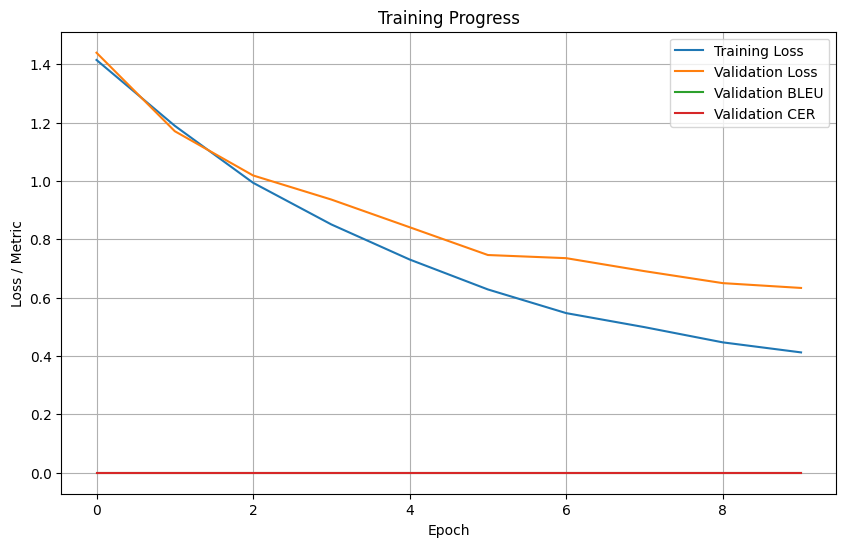


STEP 4: Testing Translation
Input Urdu: تو کبھی خود کو بھی دیکھے گا تو ڈر جائے گا
Translated Roman: to kabhi khud ko bhi dekhe ega to dar jaega
Expected Roman: tu kabhi khud ko bhi dekhega to dar jaega

Model info saved to /kaggle/working/model_info.pkl
Training pipeline completed successfully!


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import numpy as np
import random
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import pickle
from typing import List, Tuple, Optional, Dict, Set
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
from collections import defaultdict, Counter

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# ========================= BPE IMPLEMENTATION =========================

class UrduRomanBPE:
    def __init__(self, vocab_size: int = 10000):
        self.vocab_size = vocab_size
        self.urdu_vocab = {}
        self.roman_vocab = {}
        self.urdu_merges = []
        self.roman_merges = []
        self.urdu_word_freqs = defaultdict(int)
        self.roman_word_freqs = defaultdict(int)
        
        # Special tokens
        self.special_tokens = ['<PAD>', '<UNK>', '<SOS>', '<EOS>']
        
    def _get_word_tokens(self, word: str) -> List[str]:
        """Split word into characters with end-of-word marker"""
        return list(word) + ['</w>']
    
    def _get_pairs(self, word_tokens: List[str]) -> Set[Tuple[str, str]]:
        """Get all pairs of consecutive tokens in word"""
        pairs = set()
        prev_char = word_tokens[0]
        for char in word_tokens[1:]:
            pairs.add((prev_char, char))
            prev_char = char
        return pairs
    
    def _merge_vocab(self, pair: Tuple[str, str], word_freqs: Dict[List[str], int]) -> Dict[List[str], int]:
        """Merge the most frequent pair in vocabulary"""
        new_word_freqs = {}
        bigram = re.escape(' '.join(pair))
        p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
        
        for word_tokens in word_freqs:
            word_str = ' '.join(word_tokens)
            new_word_str = p.sub(''.join(pair), word_str)
            new_word_tokens = new_word_str.split()
            new_word_freqs[tuple(new_word_tokens)] = word_freqs[word_tokens]
        
        return new_word_freqs
    
    def _build_bpe(self, word_freqs: Dict[str, int], target_vocab_size: int) -> Tuple[Dict, List]:
        """Build BPE vocabulary and merges"""
        # Initialize vocabulary with character-level tokens
        vocab = set()
        word_token_freqs = {}
        
        for word, freq in word_freqs.items():
            word_tokens = self._get_word_tokens(word)
            word_token_freqs[tuple(word_tokens)] = freq
            for token in word_tokens:
                vocab.add(token)
        
        # Add special tokens
        for token in self.special_tokens:
            vocab.add(token)
        
        merges = []
        
        # Iteratively merge most frequent pairs
        while len(vocab) < target_vocab_size:
            # Get all pairs and their frequencies
            pairs = defaultdict(int)
            for word_tokens, freq in word_token_freqs.items():
                word_pairs = self._get_pairs(list(word_tokens))
                for pair in word_pairs:
                    pairs[pair] += freq
            
            if not pairs:
                break
            
            # Find most frequent pair
            best_pair = max(pairs, key=pairs.get)
            
            # Merge the pair
            word_token_freqs = self._merge_vocab(best_pair, word_token_freqs)
            merges.append(best_pair)
            vocab.add(''.join(best_pair))
        
        # Create vocabulary mapping
        vocab_dict = {token: idx for idx, token in enumerate(sorted(vocab))}
        
        return vocab_dict, merges
    
    def _preprocess_urdu_text(self, text: str) -> str:
        """Preprocess Urdu text"""
        # Remove extra whitespaces and normalize
        text = re.sub(r'\s+', ' ', text.strip())
        # Remove punctuation except for sentence boundaries
        text = re.sub(r'[۔؟!]', ' <EOS> ', text)
        text = re.sub(r'[،؍]', ' ', text)  # Remove commas and other punctuation
        return text.strip()
    
    def _preprocess_roman_text(self, text: str) -> str:
        """Preprocess Roman Urdu text"""
        # Convert to lowercase and remove extra whitespaces
        text = text.lower().strip()
        text = re.sub(r'\s+', ' ', text)
        # Handle punctuation
        text = re.sub(r'[.!?]', ' <EOS> ', text)
        text = re.sub(r'[,;:]', ' ', text)
        return text.strip()
    
    def load_data(self, urdu_file: str, roman_file: str):
        """Load and preprocess data from files"""
        print("Loading data...")
        
        try:
            with open(urdu_file, 'r', encoding='utf-8') as f:
                urdu_lines = f.readlines()
            
            with open(roman_file, 'r', encoding='utf-8') as f:
                roman_lines = f.readlines()
            
            print(f"Loaded {len(urdu_lines)} Urdu sentences and {len(roman_lines)} Roman sentences")
            
            # Process Urdu text
            for line in urdu_lines:
                line = self._preprocess_urdu_text(line)
                if line:
                    words = line.split()
                    for word in words:
                        if word not in self.special_tokens:
                            self.urdu_word_freqs[word] += 1
            
            # Process Roman text
            for line in roman_lines:
                line = self._preprocess_roman_text(line)
                if line:
                    words = line.split()
                    for word in words:
                        if word not in self.special_tokens:
                            self.roman_word_freqs[word] += 1
            
            print(f"Urdu vocabulary size: {len(self.urdu_word_freqs)}")
            print(f"Roman vocabulary size: {len(self.roman_word_freqs)}")
            
        except FileNotFoundError as e:
            print(f"Error: File not found - {e}")
            print("Please make sure the files exist at the specified paths.")
            raise
        except Exception as e:
            print(f"Error loading data: {e}")
            raise
    
    def train(self):
        """Train BPE models for both Urdu and Roman Urdu"""
        print("Training BPE models...")
        
        # Train Urdu BPE
        print("Training Urdu BPE...")
        self.urdu_vocab, self.urdu_merges = self._build_bpe(
            self.urdu_word_freqs, 
            self.vocab_size // 2
        )
        
        # Train Roman Urdu BPE
        print("Training Roman Urdu BPE...")
        self.roman_vocab, self.roman_merges = self._build_bpe(
            self.roman_word_freqs, 
            self.vocab_size // 2
        )
        
        print(f"Urdu BPE vocabulary size: {len(self.urdu_vocab)}")
        print(f"Roman BPE vocabulary size: {len(self.roman_vocab)}")
        print(f"Urdu merges: {len(self.urdu_merges)}")
        print(f"Roman merges: {len(self.roman_merges)}")
    
    def _apply_bpe(self, word: str, vocab: Dict, merges: List) -> List[str]:
        """Apply BPE encoding to a word"""
        if not word:
            return []
        
        word_tokens = self._get_word_tokens(word)
        
        if len(word_tokens) == 1:
            return word_tokens
        
        for merge in merges:
            if len(word_tokens) == 1:
                break
            
            new_word_tokens = []
            i = 0
            
            while i < len(word_tokens):
                if (i < len(word_tokens) - 1 and 
                    word_tokens[i] == merge[0] and 
                    word_tokens[i + 1] == merge[1]):
                    new_word_tokens.append(''.join(merge))
                    i += 2
                else:
                    new_word_tokens.append(word_tokens[i])
                    i += 1
            
            word_tokens = new_word_tokens
        
        return word_tokens
    
    def encode_urdu(self, text: str) -> List[int]:
        """Encode Urdu text using trained BPE"""
        text = self._preprocess_urdu_text(text)
        tokens = []
        
        for word in text.split():
            if word in self.special_tokens:
                tokens.append(self.urdu_vocab.get(word, self.urdu_vocab['<UNK>']))
            else:
                bpe_tokens = self._apply_bpe(word, self.urdu_vocab, self.urdu_merges)
                for token in bpe_tokens:
                    tokens.append(self.urdu_vocab.get(token, self.urdu_vocab['<UNK>']))
        
        return tokens
    
    def encode_roman(self, text: str) -> List[int]:
        """Encode Roman Urdu text using trained BPE"""
        text = self._preprocess_roman_text(text)
        tokens = []
        
        for word in text.split():
            if word in self.special_tokens:
                tokens.append(self.roman_vocab.get(word, self.roman_vocab['<UNK>']))
            else:
                bpe_tokens = self._apply_bpe(word, self.roman_vocab, self.roman_merges)
                for token in bpe_tokens:
                    tokens.append(self.roman_vocab.get(token, self.roman_vocab['<UNK>']))
        
        return tokens
    
    def decode_urdu(self, token_ids: List[int]) -> str:
        """Decode Urdu token IDs back to text"""
        id_to_token = {idx: token for token, idx in self.urdu_vocab.items()}
        tokens = [id_to_token.get(token_id, '<UNK>') for token_id in token_ids]
        
        # Merge tokens and remove end-of-word markers
        text = ''.join(tokens).replace('</w>', ' ')
        return text.strip()
    
    def decode_roman(self, token_ids: List[int]) -> str:
        """Decode Roman Urdu token IDs back to text"""
        id_to_token = {idx: token for token, idx in self.roman_vocab.items()}
        tokens = [id_to_token.get(token_id, '<UNK>') for token_id in token_ids]
        
        # Merge tokens and remove end-of-word markers
        text = ''.join(tokens).replace('</w>', ' ')
        return text.strip()
    
    def save_model(self, filepath: str):
        """Save trained BPE model"""
        model_data = {
            'urdu_vocab': self.urdu_vocab,
            'roman_vocab': self.roman_vocab,
            'urdu_merges': self.urdu_merges,
            'roman_merges': self.roman_merges,
            'vocab_size': self.vocab_size,
            'special_tokens': self.special_tokens
        }
        
        with open(filepath, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"Model saved to {filepath}")
    
    def load_model(self, filepath: str):
        """Load trained BPE model"""
        with open(filepath, 'rb') as f:
            model_data = pickle.load(f)
        
        self.urdu_vocab = model_data['urdu_vocab']
        self.roman_vocab = model_data['roman_vocab']
        self.urdu_merges = model_data['urdu_merges']
        self.roman_merges = model_data['roman_merges']
        self.vocab_size = model_data['vocab_size']
        self.special_tokens = model_data['special_tokens']
        print(f"Model loaded from {filepath}")


class DataProcessor:
    def __init__(self, bpe_model: UrduRomanBPE):
        self.bpe = bpe_model
    
    def prepare_training_data(self, urdu_file: str, roman_file: str, max_len: int = 50):
        """Prepare tokenized data for BiLSTM training"""
        urdu_sequences = []
        roman_sequences = []
        
        with open(urdu_file, 'r', encoding='utf-8') as f:
            urdu_lines = f.readlines()
        
        with open(roman_file, 'r', encoding='utf-8') as f:
            roman_lines = f.readlines()
        
        for urdu_line, roman_line in zip(urdu_lines, roman_lines):
            # Encode sequences
            urdu_seq = self.bpe.encode_urdu(urdu_line.strip())
            roman_seq = self.bpe.encode_roman(roman_line.strip())
            
            # Add SOS and EOS tokens
            urdu_seq = [self.bpe.urdu_vocab['<SOS>']] + urdu_seq + [self.bpe.urdu_vocab['<EOS>']]
            roman_seq = [self.bpe.roman_vocab['<SOS>']] + roman_seq + [self.bpe.roman_vocab['<EOS>']]
            
            # Truncate or pad sequences
            if len(urdu_seq) <= max_len and len(roman_seq) <= max_len:
                # Pad sequences
                while len(urdu_seq) < max_len:
                    urdu_seq.append(self.bpe.urdu_vocab['<PAD>'])
                while len(roman_seq) < max_len:
                    roman_seq.append(self.bpe.roman_vocab['<PAD>'])
                
                urdu_sequences.append(urdu_seq)
                roman_sequences.append(roman_seq)
        
        return urdu_sequences, roman_sequences
    
    def get_vocab_sizes(self):
        """Get vocabulary sizes for model initialization"""
        return len(self.bpe.urdu_vocab), len(self.bpe.roman_vocab)

# ========================= NEURAL NETWORK MODELS =========================

class BiLSTMEncoder(nn.Module):
    """BiLSTM Encoder with 2 layers"""
    
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, 
                 num_layers: int = 2, dropout: float = 0.3):
        super(BiLSTMEncoder, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # BiLSTM layers
        self.bilstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor, lengths: Optional[torch.Tensor] = None):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_len)
            lengths: Actual lengths of sequences (for packing)
        
        Returns:
            outputs: BiLSTM outputs (batch_size, seq_len, hidden_dim * 2)
            hidden: Final hidden state (num_layers * 2, batch_size, hidden_dim)
            cell: Final cell state (num_layers * 2, batch_size, hidden_dim)
        """
        batch_size = x.size(0)
        
        # Embedding
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        embedded = self.dropout(embedded)
        
        # Pack sequence if lengths are provided
        if lengths is not None:
            embedded = nn.utils.rnn.pack_padded_sequence(
                embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
            )
        
        # BiLSTM forward pass
        outputs, (hidden, cell) = self.bilstm(embedded)
        
        # Unpack if packed
        if lengths is not None:
            outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        
        return outputs, hidden, cell


class LSTMDecoder(nn.Module):
    """LSTM Decoder with 4 layers """
    
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int, 
                 encoder_hidden_dim: int, num_layers: int = 4, dropout: float = 0.3):
        super(LSTMDecoder, self).__init__()
        
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.encoder_hidden_dim = encoder_hidden_dim
        self.num_layers = num_layers
        
        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=embedding_dim + encoder_hidden_dim * 2,  # +context from attention
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.attention = nn.Linear(hidden_dim + encoder_hidden_dim * 2, encoder_hidden_dim * 2)
        
        # Output projection
        self.out_projection = nn.Linear(
            hidden_dim + encoder_hidden_dim * 2, vocab_size
        )
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x: torch.Tensor, hidden: torch.Tensor, cell: torch.Tensor,
                encoder_outputs: torch.Tensor, mask: Optional[torch.Tensor] = None):
        """
        Args:
            x: Input token (batch_size, 1)
            hidden: Previous hidden state (num_layers, batch_size, hidden_dim)
            cell: Previous cell state (num_layers, batch_size, hidden_dim)
            encoder_outputs: Encoder outputs (batch_size, enc_seq_len, enc_hidden_dim * 2)
            mask: Attention mask (batch_size, enc_seq_len)
        
        Returns:
            output: Output logits (batch_size, vocab_size)
            hidden: Updated hidden state
            cell: Updated cell state
            attention_weights: Attention weights (batch_size, enc_seq_len)
        """
        batch_size = x.size(0)
        
        # Embedding
        embedded = self.embedding(x)  # (batch_size, 1, embedding_dim)
        embedded = self.dropout(embedded)
        
        # Compute attention
        # Use top layer hidden state for attention
        top_hidden = hidden[-1].unsqueeze(1)  # (batch_size, 1, hidden_dim)
        
        # Repeat for each encoder position
        enc_seq_len = encoder_outputs.size(1)
        top_hidden_repeated = top_hidden.repeat(1, enc_seq_len, 1)  # (batch_size, enc_seq_len, hidden_dim)
        
        # Concatenate decoder hidden with encoder outputs
        attention_input = torch.cat([top_hidden_repeated, encoder_outputs], dim=2)
        
        # Compute attention scores
        attention_scores = self.attention(attention_input)  # (batch_size, enc_seq_len, enc_hidden_dim * 2)
        attention_scores = torch.sum(attention_scores * encoder_outputs, dim=2)  # (batch_size, enc_seq_len)
        
        # Apply mask if provided
        if mask is not None:
            attention_scores.masked_fill_(mask == 0, -1e9)
        
        # Softmax to get attention weights
        attention_weights = F.softmax(attention_scores, dim=1)  # (batch_size, enc_seq_len)
        
        # Compute context vector
        context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)  # (batch_size, 1, enc_hidden_dim * 2)
        
        # Concatenate embedding with context
        lstm_input = torch.cat([embedded, context], dim=2)  # (batch_size, 1, embedding_dim + enc_hidden_dim * 2)
        
        # LSTM forward pass
        lstm_out, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        
        # Concatenate LSTM output with context for final projection
        output_input = torch.cat([lstm_out.squeeze(1), context.squeeze(1)], dim=1)
        output = self.out_projection(output_input)  # (batch_size, vocab_size)
        
        return output, hidden, cell, attention_weights.squeeze(1)


class Seq2SeqModel(nn.Module):
    """Complete Seq2Seq model with BiLSTM encoder and LSTM decoder"""
    
    def __init__(self, encoder_vocab_size: int, decoder_vocab_size: int,
                 embedding_dim: int = 256, encoder_hidden_dim: int = 512,
                 decoder_hidden_dim: int = 512, encoder_layers: int = 2,
                 decoder_layers: int = 4, dropout: float = 0.3):
        super(Seq2SeqModel, self).__init__()
        
        self.encoder_vocab_size = encoder_vocab_size
        self.decoder_vocab_size = decoder_vocab_size
        self.encoder_hidden_dim = encoder_hidden_dim
        self.decoder_hidden_dim = decoder_hidden_dim
        
        # Encoder (BiLSTM)
        self.encoder = BiLSTMEncoder(
            vocab_size=encoder_vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=encoder_hidden_dim,
            num_layers=encoder_layers,
            dropout=dropout
        )
        
        # Decoder (LSTM)
        self.decoder = LSTMDecoder(
            vocab_size=decoder_vocab_size,
            embedding_dim=embedding_dim,
            hidden_dim=decoder_hidden_dim,
            encoder_hidden_dim=encoder_hidden_dim,
            num_layers=decoder_layers,
            dropout=dropout
        )
        
        # Bridge to connect encoder and decoder hidden states
        self.bridge_hidden = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.bridge_cell = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        
    def _bridge_encoder_decoder(self, encoder_hidden: torch.Tensor, encoder_cell: torch.Tensor):
        """Bridge encoder and decoder hidden states"""
        # encoder_hidden/cell: (encoder_layers * 2, batch_size, encoder_hidden_dim)
        batch_size = encoder_hidden.size(1)
        
        # Take the last layer's forward and backward hidden states
        # Forward: encoder_hidden[-2], Backward: encoder_hidden[-1]
        last_hidden = torch.cat([encoder_hidden[-2], encoder_hidden[-1]], dim=1)  # (batch_size, encoder_hidden_dim * 2)
        last_cell = torch.cat([encoder_cell[-2], encoder_cell[-1]], dim=1)
        
        # Project to decoder dimensions
        decoder_hidden = self.bridge_hidden(last_hidden)  # (batch_size, decoder_hidden_dim)
        decoder_cell = self.bridge_cell(last_cell)
        
        # Repeat for decoder layers
        decoder_hidden = decoder_hidden.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)
        decoder_cell = decoder_cell.unsqueeze(0).repeat(self.decoder.num_layers, 1, 1)
        
        return decoder_hidden, decoder_cell
    
    def forward(self, src: torch.Tensor, tgt: torch.Tensor, src_lengths: Optional[torch.Tensor] = None,
                teacher_forcing_ratio: float = 0.5):
        """
        Args:
            src: Source sequences (batch_size, src_seq_len)
            tgt: Target sequences (batch_size, tgt_seq_len)
            src_lengths: Source sequence lengths
            teacher_forcing_ratio: Probability of using teacher forcing
        
        Returns:
            outputs: Decoder outputs (batch_size, tgt_seq_len, vocab_size)
            attention_weights: Attention weights for visualization
        """
        batch_size = src.size(0)
        tgt_seq_len = tgt.size(1)
        
        # Encoder forward pass
        encoder_outputs, encoder_hidden, encoder_cell = self.encoder(src, src_lengths)
        
        # Bridge encoder and decoder
        decoder_hidden, decoder_cell = self._bridge_encoder_decoder(encoder_hidden, encoder_cell)
        
        # Create attention mask for source padding
        if src_lengths is not None:
            src_mask = torch.zeros(batch_size, src.size(1), device=src.device)
            for i, length in enumerate(src_lengths):
                src_mask[i, :length] = 1
        else:
            src_mask = (src != 0).float()  # Assume 0 is padding token
        
        # Decoder forward pass
        outputs = []
        attention_weights = []
        
        # Start with SOS token (assuming index 2)
        decoder_input = tgt[:, 0].unsqueeze(1)  # (batch_size, 1)
        
        for t in range(1, tgt_seq_len):
            # Decoder step
            output, decoder_hidden, decoder_cell, attn_weights = self.decoder(
                decoder_input, decoder_hidden, decoder_cell, encoder_outputs, src_mask
            )
            
            outputs.append(output)
            attention_weights.append(attn_weights)
            
            # Teacher forcing
            if random.random() < teacher_forcing_ratio:
                decoder_input = tgt[:, t].unsqueeze(1)  # Use ground truth
            else:
                decoder_input = output.argmax(dim=1).unsqueeze(1)  # Use prediction
        
        outputs = torch.stack(outputs, dim=1)  # (batch_size, tgt_seq_len-1, vocab_size)
        attention_weights = torch.stack(attention_weights, dim=1)  # (batch_size, tgt_seq_len-1, src_seq_len)
        
        return outputs, attention_weights
    
    def translate(self, src: torch.Tensor, max_length: int = 50, sos_token: int = 2, 
                  eos_token: int = 3, src_lengths: Optional[torch.Tensor] = None):
        """Translate a source sequence"""
        self.eval()
        
        with torch.no_grad():
            batch_size = src.size(0)
            
            # Encoder forward pass
            encoder_outputs, encoder_hidden, encoder_cell = self.encoder(src, src_lengths)
            
            # Bridge encoder and decoder
            decoder_hidden, decoder_cell = self._bridge_encoder_decoder(encoder_hidden, encoder_cell)
            
            # Create attention mask
            if src_lengths is not None:
                src_mask = torch.zeros(batch_size, src.size(1), device=src.device)
                for i, length in enumerate(src_lengths):
                    src_mask[i, :length] = 1
            else:
                src_mask = (src != 0).float()
            
            # Initialize with SOS token
            decoder_input = torch.full((batch_size, 1), sos_token, device=src.device)
            
            outputs = []
            attention_weights = []
            
            for _ in range(max_length):
                output, decoder_hidden, decoder_cell, attn_weights = self.decoder(
                    decoder_input, decoder_hidden, decoder_cell, encoder_outputs, src_mask
                )
                
                predicted = output.argmax(dim=1)
                outputs.append(predicted)
                attention_weights.append(attn_weights)
                
                decoder_input = predicted.unsqueeze(1)
                
                # Stop if all sequences have produced EOS token
                if (predicted == eos_token).all():
                    break
            
            outputs = torch.stack(outputs, dim=1)  # (batch_size, generated_length)
            attention_weights = torch.stack(attention_weights, dim=1)
            
            return outputs, attention_weights


# ========================= DATASET AND TRAINING =========================

class UrduRomanDataset(Dataset):
    """Dataset class for Urdu-Roman pairs"""
    
    def __init__(self, urdu_sequences: List[List[int]], roman_sequences: List[List[int]]):
        assert len(urdu_sequences) == len(roman_sequences)
        self.urdu_sequences = urdu_sequences
        self.roman_sequences = roman_sequences
    
    def __len__(self):
        return len(self.urdu_sequences)
    
    def __getitem__(self, idx):
        return {
            'urdu': torch.tensor(self.urdu_sequences[idx], dtype=torch.long),
            'roman': torch.tensor(self.roman_sequences[idx], dtype=torch.long)
        }


def collate_fn(batch):
    """Custom collate function for padding sequences"""
    urdu_seqs = [item['urdu'] for item in batch]
    roman_seqs = [item['roman'] for item in batch]
    
    # Get lengths before padding
    urdu_lengths = torch.tensor([len(seq) for seq in urdu_seqs])
    roman_lengths = torch.tensor([len(seq) for seq in roman_seqs])
    
    # Pad sequences
    urdu_padded = pad_sequence(urdu_seqs, batch_first=True, padding_value=0)
    roman_padded = pad_sequence(roman_seqs, batch_first=True, padding_value=0)
    
    return {
        'urdu': urdu_padded,
        'roman': roman_padded,
        'urdu_lengths': urdu_lengths,
        'roman_lengths': roman_lengths
    }


class Trainer:
    """Training class for the seq2seq model (with BLEU, PPL, CER, and qualitative examples)"""
    
    def __init__(self, model, train_dataloader: DataLoader,
                 val_dataloader: DataLoader, device: torch.device,
                 roman_bpe=None, urdu_bpe=None):
        self.model = model
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.device = device
        self.roman_bpe = roman_bpe
        self.urdu_bpe = urdu_bpe
        
        self.model.to(device)
        
        # Loss, optimizer, scheduler
        self.criterion = nn.CrossEntropyLoss(ignore_index=0)
        self.optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=3
        )
        
        # History
        self.train_losses = []
        self.val_losses = []
        self.val_bleus = []
        self.val_cers = []
    
    # -------------------------
    # Train one epoch
    # -------------------------
    def train_epoch(self, epoch: int):
        self.model.train()
        total_loss = 0
        progress_bar = tqdm(self.train_dataloader, desc=f'Epoch {epoch+1}')
        
        for batch in progress_bar:
            urdu = batch['urdu'].to(self.device)
            roman = batch['roman'].to(self.device)
            urdu_lengths = batch['urdu_lengths'].to(self.device)
            
            self.optimizer.zero_grad()
            outputs, _ = self.model(urdu, roman, urdu_lengths, teacher_forcing_ratio=0.7)
            
            targets = roman[:, 1:].contiguous().view(-1)
            outputs = outputs.view(-1, outputs.size(-1))
            
            loss = self.criterion(outputs, targets)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            
            total_loss += loss.item()
            progress_bar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        avg_loss = total_loss / len(self.train_dataloader)
        self.train_losses.append(avg_loss)
        return avg_loss
    
    # -------------------------
    # Validation (Loss, BLEU, PPL, CER)
    # -------------------------
    def validate(self, max_len=50):
        self.model.eval()
        total_loss = 0
        bleu_scores = []
        total_ed, total_tokens = 0, 0
        
        smoothie = SmoothingFunction().method4
        
        with torch.no_grad():
            for batch in self.val_dataloader:
                urdu = batch['urdu'].to(self.device)
                roman = batch['roman'].to(self.device)
                urdu_lengths = batch['urdu_lengths'].to(self.device)
                
                outputs, predictions = self.model(urdu, roman, urdu_lengths, teacher_forcing_ratio=0.0)
                
                targets = roman[:, 1:].contiguous().view(-1)
                outputs = outputs.view(-1, outputs.size(-1))
                loss = self.criterion(outputs, targets)
                total_loss += loss.item()
                
                if self.roman_bpe is not None:
                    for j in range(urdu.size(0)):
                        hyp_tokens = predictions[j].cpu().numpy()
                        hyp_text = self.roman_bpe.decode(hyp_tokens)
                        ref_tokens = roman[j].cpu().numpy()
                        ref_text = self.roman_bpe.decode(ref_tokens)
                        
                        bleu = sentence_bleu([ref_text.split()], hyp_text.split(), smoothing_function=smoothie)
                        bleu_scores.append(bleu)
                        
                        total_ed += editdistance.eval(ref_text, hyp_text)
                        total_tokens += len(ref_text)
        
        avg_loss = total_loss / len(self.val_dataloader)
        avg_bleu = np.mean(bleu_scores) if bleu_scores else 0.0
        ppl = np.exp(avg_loss)
        cer = total_ed / total_tokens if total_tokens > 0 else 0.0
        
        self.val_losses.append(avg_loss)
        self.val_bleus.append(avg_bleu)
        self.val_cers.append(cer)
        
        return avg_loss, avg_bleu, ppl, cer
    
    # -------------------------
    # Full training loop
    # -------------------------
    def train(self, num_epochs: int):
        print(f"Starting training for {num_epochs} epochs...")
        
        best_val_loss = float('inf')
        patience_counter = 0
        early_stopping_patience = 10
        
        for epoch in range(num_epochs):
            train_loss = self.train_epoch(epoch)
            val_loss, val_bleu, val_ppl, val_cer = self.validate()
            
            old_lr = self.optimizer.param_groups[0]['lr']
            self.scheduler.step(val_loss)
            new_lr = self.optimizer.param_groups[0]['lr']
            
            print(f'Epoch {epoch+1}/{num_epochs}:')
            print(f'  Train Loss: {train_loss:.4f}')
            print(f'  Val Loss: {val_loss:.4f}')
            print(f'  Val BLEU: {val_bleu:.4f}')
            print(f'  Val PPL: {val_ppl:.2f}')
            print(f'  Val CER: {val_cer:.4f}')
            print(f'  Learning Rate: {new_lr:.6f}')
            
            if old_lr != new_lr:
                print(f'  Learning rate reduced from {old_lr:.6f} to {new_lr:.6f}')
            
            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'train_losses': self.train_losses,
                    'val_losses': self.val_losses,
                    'val_bleus': self.val_bleus,
                    'val_cers': self.val_cers
                }, '/kaggle/working/best_model.pt')
                print(f'  New best model saved!')
            else:
                patience_counter += 1
            
            if patience_counter >= early_stopping_patience:
                print(f'Early stopping after {epoch+1} epochs')
                break
        
        print("Training completed!")
    
    # -------------------------
    # Plot training curves
    # -------------------------
    def plot_losses(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.train_losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        if self.val_bleus:
            plt.plot(self.val_bleus, label='Validation BLEU')
        if self.val_cers:
            plt.plot(self.val_cers, label='Validation CER')
        plt.xlabel('Epoch')
        plt.ylabel('Loss / Metric')
        plt.title('Training Progress')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # -------------------------
    # Show qualitative examples
    # -------------------------
    def evaluate_examples(self, dataloader, num_examples=5, max_len=50):
        self.model.eval()
        examples = []
        
        with torch.no_grad():
            for batch in dataloader:
                urdu = batch['urdu'].to(self.device)
                roman = batch['roman'].to(self.device)
                urdu_lengths = batch['urdu_lengths'].to(self.device)
                
                _, predictions = self.model(urdu, roman, urdu_lengths, teacher_forcing_ratio=0.0)
                
                for i in range(urdu.size(0)):
                    src_text = self.urdu_bpe.decode(urdu[i].cpu().numpy()) if self.urdu_bpe else "N/A"
                    tgt_text = self.roman_bpe.decode(roman[i].cpu().numpy()) if self.roman_bpe else "N/A"
                    pred_text = self.roman_bpe.decode(predictions[i].cpu().numpy()) if self.roman_bpe else "N/A"
                    
                    examples.append((src_text, tgt_text, pred_text))
                    if len(examples) >= num_examples:
                        break
                if len(examples) >= num_examples:
                    break
        
        print("\nQualitative Examples:")
        print("-" * 60)
        for src, tgt, pred in examples:
            print(f"SRC: {src}")
            print(f"TGT: {tgt}")
            print(f"PRED: {pred}")
            print("-" * 60)
# ========================= MAIN TRAINING FUNCTION =========================

def main():
    """Main function to train the complete pipeline"""
    
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Step 1: Train BPE model
    print("=" * 50)
    print("STEP 1: Training BPE Model")
    print("=" * 50)
    
    bpe = UrduRomanBPE(vocab_size=8000)
    
    try:
        # Try to load existing BPE model
        bpe.load_model('/kaggle/working/bpe_model.pkl')
        print("Loaded existing BPE model")
    except FileNotFoundError:
        print("Training new BPE model...")
        # Train new BPE model
        bpe.load_data('/kaggle/working/urdu.txt', '/kaggle/working/roman.txt')
        bpe.train()
        bpe.save_model('/kaggle/working/bpe_model.pkl')
    
    # Test BPE with your example
    print("\n=== Testing BPE Encoding ===")
    urdu_text = "تو کبھی خود کو بھی دیکھے گا تو ڈر جائے گا"
    roman_text = "tu kabhi khud ko bhi dekhega to dar jaega"
    
    print(f"Original Urdu: {urdu_text}")
    urdu_encoded = bpe.encode_urdu(urdu_text)
    print(f"Urdu Encoded: {urdu_encoded}")
    urdu_decoded = bpe.decode_urdu(urdu_encoded)
    print(f"Urdu Decoded: {urdu_decoded}")
    
    print(f"\nOriginal Roman: {roman_text}")
    roman_encoded = bpe.encode_roman(roman_text)
    print(f"Roman Encoded: {roman_encoded}")
    roman_decoded = bpe.decode_roman(roman_encoded)
    print(f"Roman Decoded: {roman_decoded}")
    
    # Step 2: Prepare training data
    print("\n" + "=" * 50)
    print("STEP 2: Preparing Training Data")
    print("=" * 50)
    
    processor = DataProcessor(bpe)
    urdu_seqs, roman_seqs = processor.prepare_training_data(
        '/kaggle/working/urdu.txt',
        '/kaggle/working/roman.txt',
        max_len=50
    )
    
    print(f"Prepared {len(urdu_seqs)} sequence pairs")
    
    # Split data
    split_idx = int(0.8 * len(urdu_seqs))
    train_urdu, val_urdu = urdu_seqs[:split_idx], urdu_seqs[split_idx:]
    train_roman, val_roman = roman_seqs[:split_idx], roman_seqs[split_idx:]
    
    print(f"Training samples: {len(train_urdu)}")
    print(f"Validation samples: {len(val_urdu)}")
    
    # Create datasets and dataloaders
    train_dataset = UrduRomanDataset(train_urdu, train_roman)
    val_dataset = UrduRomanDataset(val_urdu, val_roman)
    
    train_dataloader = DataLoader(
        train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn
    )
    
    # Step 3: Create and train model
    print("\n" + "=" * 50)
    print("STEP 3: Creating and Training Model")
    print("=" * 50)
    
    # Get vocabulary sizes
    encoder_vocab_size, decoder_vocab_size = processor.get_vocab_sizes()
    print(f"Encoder vocab size: {encoder_vocab_size}")
    print(f"Decoder vocab size: {decoder_vocab_size}")
    
    # Create model
    model = Seq2SeqModel(
        encoder_vocab_size=encoder_vocab_size,
        decoder_vocab_size=decoder_vocab_size,
        embedding_dim=256,
        encoder_hidden_dim=512,
        decoder_hidden_dim=512,
        encoder_layers=2,  # BiLSTM with 2 layers
        decoder_layers=4,  # LSTM with 4 layers
        dropout=0.3
    )
    
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model created with {total_params:,} total parameters")
    print(f"Trainable parameters: {trainable_params:,}")
    
    # Create trainer and train
    trainer = Trainer(model, train_dataloader, val_dataloader, device)
    trainer.train(num_epochs=10)
    
    # Plot losses
    trainer.plot_losses()
    
    # Step 4: Test translation
    print("\n" + "=" * 50)
    print("STEP 4: Testing Translation")
    print("=" * 50)
    
    # Load best model
    checkpoint = torch.load('/kaggle/working/best_model.pt', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    # Test with example
    test_urdu = "تو کبھی خود کو بھی دیکھے گا تو ڈر جائے گا"
    urdu_tokens = bpe.encode_urdu(test_urdu)
    
    # Add SOS and EOS tokens
    urdu_tokens = [bpe.urdu_vocab['<SOS>']] + urdu_tokens + [bpe.urdu_vocab['<EOS>']]
    urdu_tensor = torch.tensor([urdu_tokens], device=device)
    
    with torch.no_grad():
        translated, attention = model.translate(
            urdu_tensor, 
            max_length=50,
            sos_token=bpe.roman_vocab['<SOS>'],
            eos_token=bpe.roman_vocab['<EOS>']
        )
    
    # Decode translation
    translated_tokens = translated[0].cpu().tolist()
    # Remove special tokens for cleaner output
    clean_tokens = [t for t in translated_tokens if t not in [
        bpe.roman_vocab['<PAD>'], 
        bpe.roman_vocab['<SOS>'], 
        bpe.roman_vocab['<EOS>']
    ]]
    translated_text = bpe.decode_roman(clean_tokens)
    
    print(f"Input Urdu: {test_urdu}")
    print(f"Translated Roman: {translated_text}")
    print(f"Expected Roman: tu kabhi khud ko bhi dekhega to dar jaega")
    
    # Save final model info
    model_info = {
        'encoder_vocab_size': encoder_vocab_size,
        'decoder_vocab_size': decoder_vocab_size,
        'model_architecture': {
            'encoder_layers': 2,
            'decoder_layers': 4,
            'embedding_dim': 256,
            'encoder_hidden_dim': 512,
            'decoder_hidden_dim': 512
        },
        'total_parameters': total_params,
        'training_history': {
            'train_losses': trainer.train_losses,
            'val_losses': trainer.val_losses
        }
    }
    
    with open('/kaggle/working/model_info.pkl', 'wb') as f:
        pickle.dump(model_info, f)
    
    print(f"\nModel info saved to /kaggle/working/model_info.pkl")
    print("Training pipeline completed successfully!")


if __name__ == "__main__":
    main()

Choose testing mode:
1. Quick Test (predefined examples)
2. Comprehensive Test (with evaluation)
3. Interactive Mode
4. Custom Test


Enter your choice (1-4):  2


Model loaded from /kaggle/working/bpe_model.pkl
Model loaded successfully on cuda
Urdu vocab size: 4000
Roman vocab size: 4000
Training Curves:


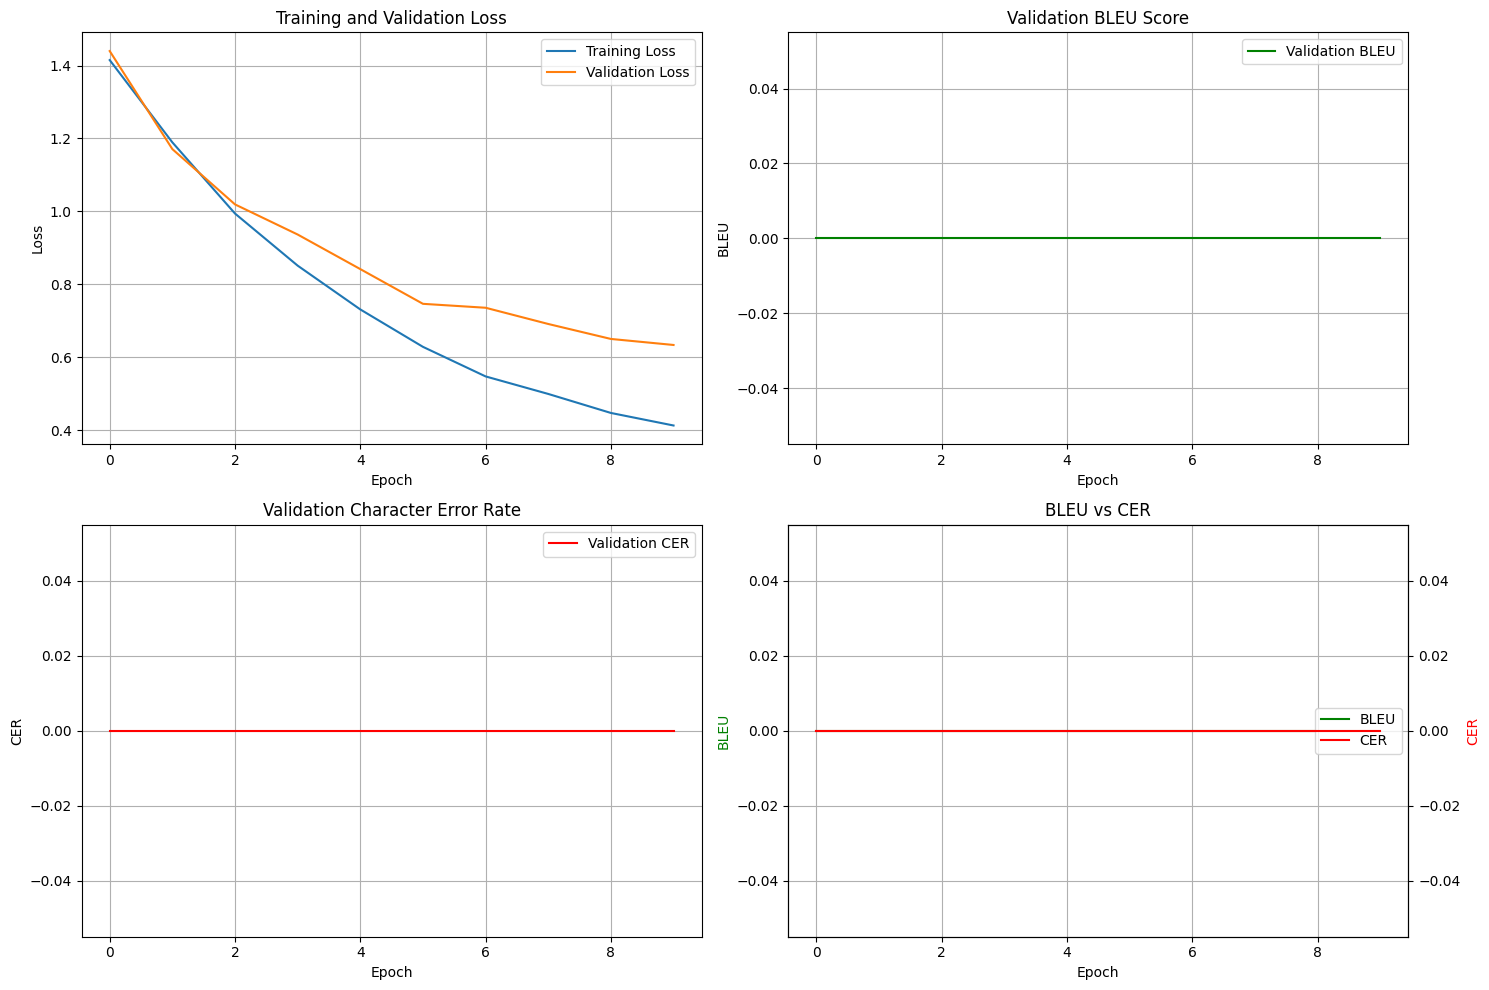

Evaluating on test set...
Evaluating on 1000 samples...
Processed 0/1000 samples...
Processed 100/1000 samples...
Processed 200/1000 samples...
Processed 300/1000 samples...
Processed 400/1000 samples...
Processed 500/1000 samples...
Processed 600/1000 samples...
Processed 700/1000 samples...
Processed 800/1000 samples...
Processed 900/1000 samples...

Evaluation Results:
Average BLEU: 0.5534
Character Error Rate (CER): 0.1800
Samples evaluated: 1000
TRANSLATION EXAMPLES

Example 1:
Urdu Input:  آنکھ سے دور نہ ہو دل سے اتر جائے گا
Prediction:  na se duur na ho dil se utar jaega
Expected:    aankh se duur na ho dil se utar jaega
BLEU Score:  0.8633
--------------------------------------------------------------------------------

Example 2:
Urdu Input:  وقت کا کیا ہے گزرتا ہے گزر جائے گا
Prediction:  vaqt ka kya hai guzarta hai guzar jaega
Expected:    vaqt ka kya hai guzarta hai guzar jaega
BLEU Score:  1.0000
-----------------------------------------------------------------------------

In [5]:
# ========================= MODEL TESTING FUNCTIONS =========================

import torch
import pickle
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import editdistance
from typing import List, Dict, Tuple, Optional
import matplotlib.pyplot as plt
import seaborn as sns

class ModelTester:
    """Class for testing the trained Urdu-Roman translation model"""
    
    def __init__(self, model_path: str, bpe_model_path: str, device: torch.device):
        """
        Initialize the model tester
        
        Args:
            model_path: Path to the trained model checkpoint
            bpe_model_path: Path to the trained BPE model
            device: Device to run inference on
        """
        self.device = device
        
        # Load BPE model
        self.bpe = UrduRomanBPE()
        self.bpe.load_model(bpe_model_path)
        
        # Load trained model
        self._load_model(model_path)
        
        print(f"Model loaded successfully on {device}")
        print(f"Urdu vocab size: {len(self.bpe.urdu_vocab)}")
        print(f"Roman vocab size: {len(self.bpe.roman_vocab)}")
    
    def _load_model(self, model_path: str):
        """Load the trained model"""
        checkpoint = torch.load(model_path, map_location=self.device)
        
        # Get vocabulary sizes
        encoder_vocab_size = len(self.bpe.urdu_vocab)
        decoder_vocab_size = len(self.bpe.roman_vocab)
        
        # Recreate model with same architecture
        self.model = Seq2SeqModel(
            encoder_vocab_size=encoder_vocab_size,
            decoder_vocab_size=decoder_vocab_size,
            embedding_dim=256,
            encoder_hidden_dim=512,
            decoder_hidden_dim=512,
            encoder_layers=2,
            decoder_layers=4,
            dropout=0.3
        )
        
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.to(self.device)
        self.model.eval()
        
        # Store training history if available
        self.train_losses = checkpoint.get('train_losses', [])
        self.val_losses = checkpoint.get('val_losses', [])
        self.val_bleus = checkpoint.get('val_bleus', [])
        self.val_cers = checkpoint.get('val_cers', [])
    
    def translate_single(self, urdu_text: str, max_length: int = 50, 
                        show_attention: bool = False) -> Dict:
        """
        Translate a single Urdu sentence to Roman Urdu
        
        Args:
            urdu_text: Input Urdu text
            max_length: Maximum length for translation
            show_attention: Whether to return attention weights
        
        Returns:
            Dictionary containing translation results
        """
        # Preprocess and encode input
        urdu_tokens = self.bpe.encode_urdu(urdu_text)
        urdu_tokens = [self.bpe.urdu_vocab['<SOS>']] + urdu_tokens + [self.bpe.urdu_vocab['<EOS>']]
        urdu_tensor = torch.tensor([urdu_tokens], device=self.device)
        
        # Generate translation
        with torch.no_grad():
            translated, attention_weights = self.model.translate(
                urdu_tensor,
                max_length=max_length,
                sos_token=self.bpe.roman_vocab['<SOS>'],
                eos_token=self.bpe.roman_vocab['<EOS>']
            )
        
        # Decode translation
        translated_tokens = translated[0].cpu().tolist()
        
        # Remove special tokens for cleaner output
        clean_tokens = []
        for token in translated_tokens:
            if token == self.bpe.roman_vocab['<EOS>']:
                break
            if token not in [self.bpe.roman_vocab['<PAD>'], self.bpe.roman_vocab['<SOS>']]:
                clean_tokens.append(token)
        
        translated_text = self.bpe.decode_roman(clean_tokens)
        
        result = {
            'input_urdu': urdu_text,
            'translated_roman': translated_text,
            'input_tokens': urdu_tokens,
            'output_tokens': clean_tokens
        }
        
        if show_attention:
            result['attention_weights'] = attention_weights[0].cpu().numpy()
        
        return result
    
    def translate_batch(self, urdu_texts: List[str], max_length: int = 50) -> List[Dict]:
        """
        Translate a batch of Urdu sentences
        
        Args:
            urdu_texts: List of Urdu texts
            max_length: Maximum length for translation
        
        Returns:
            List of translation results
        """
        results = []
        
        for urdu_text in urdu_texts:
            result = self.translate_single(urdu_text, max_length)
            results.append(result)
        
        return results
    
    def interactive_test(self):
        """
        Interactive testing mode - input Urdu text and get translations
        """
        print("="*60)
        print("INTERACTIVE TRANSLATION MODE")
        print("="*60)
        print("Enter Urdu text to translate (type 'quit' to exit):")
        
        while True:
            try:
                urdu_input = input("\nUrdu: ").strip()
                
                if urdu_input.lower() in ['quit', 'exit', 'q']:
                    print("Exiting interactive mode...")
                    break
                
                if not urdu_input:
                    print("Please enter some text.")
                    continue
                
                result = self.translate_single(urdu_input, show_attention=False)
                print(f"Roman: {result['translated_roman']}")
                
            except KeyboardInterrupt:
                print("\nExiting interactive mode...")
                break
            except Exception as e:
                print(f"Error: {e}")
    
    def evaluate_on_test_set(self, urdu_file: str, roman_file: str, 
                           max_samples: Optional[int] = None) -> Dict:
        """
        Evaluate model on a test set
        
        Args:
            urdu_file: Path to Urdu test file
            roman_file: Path to Roman test file
            max_samples: Maximum number of samples to evaluate
        
        Returns:
            Dictionary containing evaluation metrics
        """
        print("Evaluating on test set...")
        
        # Load test data
        with open(urdu_file, 'r', encoding='utf-8') as f:
            urdu_lines = [line.strip() for line in f.readlines()]
        
        with open(roman_file, 'r', encoding='utf-8') as f:
            roman_lines = [line.strip() for line in f.readlines()]
        
        # Limit samples if specified
        if max_samples:
            urdu_lines = urdu_lines[:max_samples]
            roman_lines = roman_lines[:max_samples]
        
        print(f"Evaluating on {len(urdu_lines)} samples...")
        
        bleu_scores = []
        edit_distances = []
        total_chars_ref = 0
        smoothie = SmoothingFunction().method4
        
        results = []
        
        for i, (urdu_text, roman_ref) in enumerate(zip(urdu_lines, roman_lines)):
            if i % 100 == 0:
                print(f"Processed {i}/{len(urdu_lines)} samples...")
            
            # Translate
            result = self.translate_single(urdu_text)
            roman_pred = result['translated_roman']
            
            # Calculate BLEU
            ref_tokens = roman_ref.lower().split()
            pred_tokens = roman_pred.lower().split()
            
            if pred_tokens:  # Avoid empty predictions
                bleu = sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)
                bleu_scores.append(bleu)
            
            # Calculate edit distance (for CER)
            ed = editdistance.eval(roman_ref.lower(), roman_pred.lower())
            edit_distances.append(ed)
            total_chars_ref += len(roman_ref)
            
            # Store result for analysis
            results.append({
                'urdu': urdu_text,
                'reference': roman_ref,
                'prediction': roman_pred,
                'bleu': bleu if pred_tokens else 0.0,
                'edit_distance': ed
            })
        
        # Calculate metrics
        avg_bleu = np.mean(bleu_scores) if bleu_scores else 0.0
        cer = sum(edit_distances) / total_chars_ref if total_chars_ref > 0 else 0.0
        
        evaluation_results = {
            'avg_bleu': avg_bleu,
            'cer': cer,
            'num_samples': len(urdu_lines),
            'bleu_scores': bleu_scores,
            'edit_distances': edit_distances,
            'detailed_results': results
        }
        
        print(f"\nEvaluation Results:")
        print(f"Average BLEU: {avg_bleu:.4f}")
        print(f"Character Error Rate (CER): {cer:.4f}")
        print(f"Samples evaluated: {len(urdu_lines)}")
        
        return evaluation_results
    
    def show_examples(self, urdu_texts: List[str], expected_romans: Optional[List[str]] = None,
                     num_examples: int = 5):
        """
        Show translation examples with formatting
        
        Args:
            urdu_texts: List of Urdu texts
            expected_romans: Optional list of expected Roman translations
            num_examples: Number of examples to show
        """
        print("="*80)
        print("TRANSLATION EXAMPLES")
        print("="*80)
        
        for i, urdu_text in enumerate(urdu_texts[:num_examples]):
            result = self.translate_single(urdu_text)
            
            print(f"\nExample {i+1}:")
            print(f"Urdu Input:  {urdu_text}")
            print(f"Prediction:  {result['translated_roman']}")
            
            if expected_romans and i < len(expected_romans):
                print(f"Expected:    {expected_romans[i]}")
                
                # Calculate BLEU for this example
                ref_tokens = expected_romans[i].lower().split()
                pred_tokens = result['translated_roman'].lower().split()
                if pred_tokens:
                    bleu = sentence_bleu([ref_tokens], pred_tokens, 
                                       smoothing_function=SmoothingFunction().method4)
                    print(f"BLEU Score:  {bleu:.4f}")
            
            print("-" * 80)
    
    def visualize_attention(self, urdu_text: str, max_length: int = 50):
        """
        Visualize attention weights for a translation
        
        Args:
            urdu_text: Input Urdu text
            max_length: Maximum translation length
        """
        result = self.translate_single(urdu_text, max_length, show_attention=True)
        
        if 'attention_weights' not in result:
            print("Attention weights not available")
            return
        
        attention = result['attention_weights']  # (tgt_len, src_len)
        
        # Get tokens for labeling
        urdu_tokens = self.bpe.encode_urdu(urdu_text)
        urdu_tokens = ['<SOS>'] + [self.bpe.decode_urdu([t]) for t in urdu_tokens] + ['<EOS>']
        
        roman_tokens = result['translated_roman'].split()
        
        # Create attention plot
        plt.figure(figsize=(12, 8))
        sns.heatmap(attention[:len(roman_tokens), :len(urdu_tokens)], 
                   xticklabels=urdu_tokens[:len(urdu_tokens)], 
                   yticklabels=roman_tokens[:len(roman_tokens)],
                   cmap='Blues', cbar=True)
        
        plt.title(f'Attention Visualization\nUrdu: {urdu_text}\nRoman: {result["translated_roman"]}')
        plt.xlabel('Source (Urdu)')
        plt.ylabel('Target (Roman)')
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    def plot_training_curves(self):
        """Plot training curves if available"""
        if not self.train_losses:
            print("Training history not available")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        # Training and validation loss
        axes[0, 0].plot(self.train_losses, label='Training Loss')
        if self.val_losses:
            axes[0, 0].plot(self.val_losses, label='Validation Loss')
        axes[0, 0].set_title('Training and Validation Loss')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # BLEU scores
        if self.val_bleus:
            axes[0, 1].plot(self.val_bleus, label='Validation BLEU', color='green')
            axes[0, 1].set_title('Validation BLEU Score')
            axes[0, 1].set_xlabel('Epoch')
            axes[0, 1].set_ylabel('BLEU')
            axes[0, 1].legend()
            axes[0, 1].grid(True)
        
        # CER scores
        if self.val_cers:
            axes[1, 0].plot(self.val_cers, label='Validation CER', color='red')
            axes[1, 0].set_title('Validation Character Error Rate')
            axes[1, 0].set_xlabel('Epoch')
            axes[1, 0].set_ylabel('CER')
            axes[1, 0].legend()
            axes[1, 0].grid(True)
        
        # Combined metrics
        if self.val_bleus and self.val_cers:
            ax2 = axes[1, 1]
            ax3 = ax2.twinx()
            
            line1 = ax2.plot(self.val_bleus, 'g-', label='BLEU')
            line2 = ax3.plot(self.val_cers, 'r-', label='CER')
            
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('BLEU', color='g')
            ax3.set_ylabel('CER', color='r')
            
            lines = line1 + line2
            labels = [l.get_label() for l in lines]
            ax2.legend(lines, labels, loc='center right')
            ax2.set_title('BLEU vs CER')
            ax2.grid(True)
        
        plt.tight_layout()
        plt.show()


# ========================= USAGE FUNCTIONS =========================

def quick_test(model_path: str = '/kaggle/working/best_model.pt', 
               bpe_path: str = '/kaggle/working/bpe_model.pkl'):
    """
    Quick test function with predefined examples
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tester = ModelTester(model_path, bpe_path, device)
    
    # Test examples
    test_sentences = [
        "تو کبھی خود کو بھی دیکھے گا تو ڈر جائے گا",
        "میں آپ سے محبت کرتا ہوں",
        "آج موسم بہت اچھا ہے",
        "کل میں سکول جاؤں گا",
        "یہ کتاب بہت دلچسپ ہے"
    ]
    
    expected_translations = [
        "tu kabhi khud ko bhi dekhega to dar jaega",
        "main aap se mohabbat karta hun",
        "aaj mausam bohat acha hai",
        "kal main school jaunga",
        "ye kitab bohat dilchasp hai"
    ]
    
    print("Quick Test Results:")
    tester.show_examples(test_sentences, expected_translations)
    
    return tester

def comprehensive_test(model_path: str = '/kaggle/working/best_model.pt',
                      bpe_path: str = '/kaggle/working/bpe_model.pkl',
                      test_urdu_file: str = '/kaggle/working/urdu.txt',
                      test_roman_file: str = '/kaggle/working/roman.txt',
                      max_samples: int = 1000):
    """
    Comprehensive test with evaluation metrics
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tester = ModelTester(model_path, bpe_path, device)
    
    # Show training curves
    print("Training Curves:")
    tester.plot_training_curves()
    
    # Evaluate on test set
    eval_results = tester.evaluate_on_test_set(
        test_urdu_file, test_roman_file, max_samples
    )
    
    # Show some examples
    with open(test_urdu_file, 'r', encoding='utf-8') as f:
        urdu_samples = [line.strip() for line in f.readlines()[:10]]
    
    with open(test_roman_file, 'r', encoding='utf-8') as f:
        roman_samples = [line.strip() for line in f.readlines()[:10]]
    
    tester.show_examples(urdu_samples, roman_samples)
    
    return tester, eval_results

def interactive_mode(model_path: str = '/kaggle/working/best_model.pt',
                    bpe_path: str = '/kaggle/working/bpe_model.pkl'):
    """
    Start interactive translation mode
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    tester = ModelTester(model_path, bpe_path, device)
    tester.interactive_test()
    return tester


# ========================= MAIN TESTING SCRIPT =========================

if __name__ == "__main__":
    print("Choose testing mode:")
    print("1. Quick Test (predefined examples)")
    print("2. Comprehensive Test (with evaluation)")
    print("3. Interactive Mode")
    print("4. Custom Test")
    
    choice = input("Enter your choice (1-4): ").strip()
    
    if choice == '1':
        tester = quick_test()
    elif choice == '2':
        tester, results = comprehensive_test()
    elif choice == '3':
        tester = interactive_mode()
    elif choice == '4':
        # Custom test example
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        tester = ModelTester('/kaggle/working/best_model.pt', 
                           '/kaggle/working/bpe_model.pkl', device)
        
        # Test your own sentences
        custom_sentences = [
            "آپ کیسے ہیں؟",
            "شکریہ آپ کا"
        ]
        
        results = tester.translate_batch(custom_sentences)
        for result in results:
            print(f"Urdu: {result['input_urdu']}")
            print(f"Roman: {result['translated_roman']}")
            print("-" * 40)
    
    else:
        print("Invalid choice!")

In [6]:
%%writefile requirements.txt
torch>=1.9.0
numpy>=1.21.0
pandas>=1.3.0
streamlit>=1.28.0
matplotlib>=3.4.0
seaborn>=0.11.0
tqdm>=4.62.0
nltk>=3.6.0
editdistance>=0.6.0
sentencepiece>=0.1.96
pyngrok>=7.0.0

Writing requirements.txt


In [7]:
%%writefile app.py
import os
import io
import json
import time
import math
import pickle
from typing import List, Optional, Dict, Tuple
import re
from collections import defaultdict

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import streamlit as st
import matplotlib.pyplot as plt

# -------------------------
# Constants (Kaggle defaults)
# -------------------------
DEFAULT_BPE_PATH = "/kaggle/working/bpe_model.pkl"
DEFAULT_CKPT_PATH = "/kaggle/working/best_model.pt"
DEFAULT_URDU_FILE = "/kaggle/working/urdu.txt"
DEFAULT_ROMAN_FILE = "/kaggle/working/roman.txt"

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------------------------
# BPE Implementation
# -------------------------
class UrduRomanBPE:
    def __init__(self):
        self.vocab_size = None
        self.urdu_vocab = {}
        self.roman_vocab = {}
        self.urdu_merges = []
        self.roman_merges = []
        self.special_tokens = ['<PAD>', '<UNK>', '<SOS>', '<EOS>']

    def load_model(self, filepath: str):
        with open(filepath, "rb") as f:
            data = pickle.load(f)
        self.urdu_vocab = data['urdu_vocab']
        self.roman_vocab = data['roman_vocab']
        self.urdu_merges = data['urdu_merges']
        self.roman_merges = data['roman_merges']
        self.vocab_size = data['vocab_size']
        self.special_tokens = data.get('special_tokens', self.special_tokens)

    def _preprocess_urdu_text(self, text: str) -> str:
        text = re.sub(r'\s+', ' ', text.strip())
        text = re.sub(r'[۔؟!]', ' <EOS> ', text)
        text = re.sub(r'[،؍]', ' ', text)
        return text.strip()

    def _preprocess_roman_text(self, text: str) -> str:
        text = text.lower().strip()
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'[.!?]', ' <EOS> ', text)
        text = re.sub(r'[,;:]', ' ', text)
        return text.strip()

    def _get_word_tokens(self, word: str) -> List[str]:
        return list(word) + ['</w>']

    def _apply_bpe(self, word: str, vocab: Dict, merges: List[Tuple[str, str]]) -> List[str]:
        if not word:
            return []
        word_tokens = self._get_word_tokens(word)
        if len(word_tokens) == 1:
            return word_tokens
        
        for merge in merges:
            if len(word_tokens) == 1:
                break
            new_word_tokens = []
            i = 0
            while i < len(word_tokens):
                if (i < len(word_tokens) - 1 and
                    word_tokens[i] == merge[0] and
                    word_tokens[i + 1] == merge[1]):
                    new_word_tokens.append(''.join(merge))
                    i += 2
                else:
                    new_word_tokens.append(word_tokens[i])
                    i += 1
            word_tokens = new_word_tokens
        return word_tokens

    def encode_urdu(self, text: str) -> List[int]:
        text = self._preprocess_urdu_text(text)
        tokens = []
        for word in text.split():
            if word in self.special_tokens:
                tokens.append(self.urdu_vocab.get(word, self.urdu_vocab['<UNK>']))
            else:
                for tok in self._apply_bpe(word, self.urdu_vocab, self.urdu_merges):
                    tokens.append(self.urdu_vocab.get(tok, self.urdu_vocab['<UNK>']))
        return tokens

    def decode_roman(self, token_ids: List[int]) -> str:
        id_to_token = {idx: token for token, idx in self.roman_vocab.items()}
        toks = [id_to_token.get(t, '<UNK>') for t in token_ids]
        text = ''.join(toks).replace('</w>', ' ')
        return text.strip()

# -------------------------
# Model Architecture (same as before)
# -------------------------
class BiLSTMEncoder(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int,
                 num_layers: int = 2, dropout: float = 0.3):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.bilstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, lengths: Optional[torch.Tensor] = None):
        emb = self.dropout(self.embedding(x))
        if lengths is not None:
            emb = nn.utils.rnn.pack_padded_sequence(emb, lengths.cpu(), batch_first=True, enforce_sorted=False)
        outputs, (hidden, cell) = self.bilstm(emb)
        if lengths is not None:
            outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        return outputs, hidden, cell

class LSTMDecoder(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, hidden_dim: int,
                 encoder_hidden_dim: int, num_layers: int = 4, dropout: float = 0.3):
        super().__init__()
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(
            input_size=embedding_dim + encoder_hidden_dim * 2,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        self.attn = nn.Linear(hidden_dim + encoder_hidden_dim * 2, encoder_hidden_dim * 2)
        self.out = nn.Linear(hidden_dim + encoder_hidden_dim * 2, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, hidden: torch.Tensor, cell: torch.Tensor,
                encoder_outputs: torch.Tensor, mask: Optional[torch.Tensor] = None):
        emb = self.dropout(self.embedding(x))
        top_hidden = hidden[-1].unsqueeze(1)
        enc_len = encoder_outputs.size(1)
        top_rep = top_hidden.repeat(1, enc_len, 1)
        att_in = torch.cat([top_rep, encoder_outputs], dim=2)
        scores = self.attn(att_in)
        scores = torch.sum(scores * encoder_outputs, dim=2)
        if mask is not None:
            scores.masked_fill_(mask == 0, -1e9)
        att_w = F.softmax(scores, dim=1)
        context = torch.bmm(att_w.unsqueeze(1), encoder_outputs)
        lstm_in = torch.cat([emb, context], dim=2)
        lstm_out, (hidden, cell) = self.lstm(lstm_in, (hidden, cell))
        out_in = torch.cat([lstm_out.squeeze(1), context.squeeze(1)], dim=1)
        logits = self.out(out_in)
        return logits, hidden, cell, att_w

class Seq2SeqModel(nn.Module):
    def __init__(self, encoder_vocab_size: int, decoder_vocab_size: int,
                 embedding_dim: int = 256, encoder_hidden_dim: int = 512,
                 decoder_hidden_dim: int = 512, encoder_layers: int = 2,
                 decoder_layers: int = 4, dropout: float = 0.3):
        super().__init__()
        self.encoder = BiLSTMEncoder(encoder_vocab_size, embedding_dim, encoder_hidden_dim,
                                   num_layers=encoder_layers, dropout=dropout)
        self.decoder = LSTMDecoder(decoder_vocab_size, embedding_dim, decoder_hidden_dim,
                                 encoder_hidden_dim, num_layers=decoder_layers, dropout=dropout)
        self.bridge_hidden = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.bridge_cell = nn.Linear(encoder_hidden_dim * 2, decoder_hidden_dim)
        self.decoder_layers = decoder_layers

    def _bridge(self, h: torch.Tensor, c: torch.Tensor):
        last_h = torch.cat([h[-2], h[-1]], dim=1)
        last_c = torch.cat([c[-2], c[-1]], dim=1)
        dh = self.bridge_hidden(last_h).unsqueeze(0).repeat(self.decoder_layers, 1, 1)
        dc = self.bridge_cell(last_c).unsqueeze(0).repeat(self.decoder_layers, 1, 1)
        return dh, dc

    def translate(self, src: torch.Tensor, max_length: int, sos_token: int, eos_token: int,
                  src_lengths: Optional[torch.Tensor] = None):
        self.eval()
        with torch.no_grad():
            B = src.size(0)
            enc_out, enc_h, enc_c = self.encoder(src, src_lengths)
            dec_h, dec_c = self._bridge(enc_h, enc_c)
            if src_lengths is not None:
                mask = torch.zeros(B, src.size(1), device=src.device)
                for i, L in enumerate(src_lengths):
                    mask[i, :L] = 1
            else:
                mask = (src != 0).float()
            dec_in = torch.full((B, 1), sos_token, device=src.device, dtype=torch.long)
            outputs = []
            attns = []
            for _ in range(max_length):
                logit, dec_h, dec_c, att_w = self.decoder(dec_in, dec_h, dec_c, enc_out, mask)
                pred = logit.argmax(dim=1)
                outputs.append(pred)
                attns.append(att_w)
                dec_in = pred.unsqueeze(1)
                if (pred == eos_token).all():
                    break
            return torch.stack(outputs, dim=1), torch.stack(attns, dim=1)

# -------------------------
# Caching functions (FIXED)
# -------------------------
@st.cache_resource(show_spinner=True)
def load_bpe(bpe_path: str):
    bpe = UrduRomanBPE()
    bpe.load_model(bpe_path)
    return bpe

@st.cache_resource(show_spinner=True)
def load_model(ckpt_path: str, _bpe: UrduRomanBPE):  # Added underscore to prevent hashing
    enc_vocab = len(_bpe.urdu_vocab)
    dec_vocab = len(_bpe.roman_vocab)
    model = Seq2SeqModel(encoder_vocab_size=enc_vocab, decoder_vocab_size=dec_vocab,
                        embedding_dim=256, encoder_hidden_dim=512, decoder_hidden_dim=512,
                        encoder_layers=2, decoder_layers=4, dropout=0.3)
    ckpt = torch.load(ckpt_path, map_location=DEVICE)
    model.load_state_dict(ckpt['model_state_dict'])
    model.to(DEVICE)
    model.eval()
    history = {
        'train_losses': ckpt.get('train_losses', []),
        'val_losses': ckpt.get('val_losses', []),
        'val_bleus': ckpt.get('val_bleus', []),
        'val_cers': ckpt.get('val_cers', []),
    }
    return model, history

# -------------------------
# Helper functions (same as before)
# -------------------------
def make_src_tensor(bpe: UrduRomanBPE, urdu_texts: List[str], max_len: int = 50) -> Tuple[torch.Tensor, torch.Tensor]:
    sos = bpe.urdu_vocab['<SOS>']; eos = bpe.urdu_vocab['<EOS>']; pad = bpe.urdu_vocab['<PAD>']
    seqs = []
    lens = []
    for t in urdu_texts:
        ids = bpe.encode_urdu(t)
        ids = [sos] + ids + [eos]
        lens.append(min(len(ids), max_len))
        ids = ids[:max_len]
        if len(ids) < max_len:
            ids = ids + [pad]*(max_len - len(ids))
        seqs.append(ids)
    tens = torch.tensor(seqs, dtype=torch.long, device=DEVICE)
    lens = torch.tensor(lens, dtype=torch.long, device=DEVICE)
    return tens, lens

def decode_pred_tokens(bpe: UrduRomanBPE, pred_ids: List[int]) -> str:
    pad = bpe.roman_vocab['<PAD>']; sos = bpe.roman_vocab['<SOS>']; eos = bpe.roman_vocab['<EOS>']
    cleaned = []
    for t in pred_ids:
        if t == eos:
            break
        if t in (pad, sos):
            continue
        cleaned.append(t)
    return bpe.decode_roman(cleaned)

def draw_attention(attn: np.ndarray, urdu_tokens_vis: List[str], roman_tokens_vis: List[str]):
    fig, ax = plt.subplots(figsize=(min(12, 1 + 0.6*len(urdu_tokens_vis)), min(8, 1 + 0.5*len(roman_tokens_vis))))
    im = ax.imshow(attn, aspect='auto')
    ax.set_xticks(np.arange(len(urdu_tokens_vis)))
    ax.set_xticklabels(urdu_tokens_vis, rotation=45, ha='right')
    ax.set_yticks(np.arange(len(roman_tokens_vis)))
    ax.set_yticklabels(roman_tokens_vis)
    ax.set_xlabel("Source (Urdu tokens incl. <SOS>/<EOS>)")
    ax.set_ylabel("Generated Roman tokens")
    ax.set_title("Attention heatmap")
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    st.pyplot(fig)

def urdu_token_visuals(bpe: UrduRomanBPE, urdu_text: str, max_len: int = 50) -> List[str]:
    ids = bpe.encode_urdu(urdu_text)
    ids = [bpe.urdu_vocab['<SOS>']] + ids + [bpe.urdu_vocab['<EOS>']]
    id2tok = {idx: tok for tok, idx in bpe.urdu_vocab.items()}
    toks = [id2tok.get(i, '<UNK>') for i in ids][:max_len]
    return toks

# -------------------------
# Streamlit UI (same as before)
# -------------------------
st.set_page_config(page_title="Urdu → Roman Urdu (Seq2Seq + BPE)", page_icon="🔤", layout="wide")
st.title("🔤 Urdu → Roman Urdu Translator (Seq2Seq + BPE)")
st.caption(f"Device: **{DEVICE}** · Loads your `bpe_model.pkl` + `best_model.pt` from /kaggle/working by default.")

with st.sidebar:
    st.header("Artifacts")
    bpe_path = st.text_input("Path to BPE model (.pkl)", value=DEFAULT_BPE_PATH)
    ckpt_path = st.text_input("Path to trained checkpoint (.pt)", value=DEFAULT_CKPT_PATH)
    max_len = st.slider("Max sequence length", min_value=16, max_value=200, value=50, step=2)
    show_prob = st.checkbox("(For debug) show raw IDs", value=False)

    load_btn = st.button("Load / Reload Artifacts")

# Load BPE
if 'bpe' not in st.session_state or load_btn:
    try:
        st.session_state.bpe = load_bpe(bpe_path)
        st.success("BPE loaded.")
    except Exception as e:
        st.error(f"Failed to load BPE: {e}")

# Load Model
if 'model' not in st.session_state or load_btn:
    try:
        if 'bpe' in st.session_state:
            st.session_state.model, st.session_state.history = load_model(ckpt_path, st.session_state.bpe)
            st.success("Model loaded.")
        else:
            st.warning("Load BPE first.")
    except Exception as e:
        st.error(f"Failed to load model: {e}")

bpe = st.session_state.get('bpe', None)
model = st.session_state.get('model', None)
history = st.session_state.get('history', {'train_losses':[], 'val_losses':[], 'val_bleus':[], 'val_cers':[]})

col1, col2 = st.columns([1,1])

# Single translation
with col1:
    st.subheader("Single Translation")
    urdu_text = st.text_area("Urdu text", value="تو کبھی خود کو بھی دیکھے گا تو ڈر جائے گا", height=120)
    run_single = st.button("Translate")
    if run_single and bpe is not None and model is not None:
        src, src_len = make_src_tensor(bpe, [urdu_text], max_len=max_len)
        sos_t = bpe.roman_vocab['<SOS>']; eos_t = bpe.roman_vocab['<EOS>']
        t0 = time.time()
        preds, attns = model.translate(src, max_length=max_len, sos_token=sos_t, eos_token=eos_t, src_lengths=src_len)
        infer_ms = (time.time() - t0)*1000.0
        pred_ids = preds[0].detach().cpu().tolist()
        roman = decode_pred_tokens(bpe, pred_ids)
        st.write(f"**Roman:** {roman}")
        st.caption(f"Inference: {infer_ms:.1f} ms")
        if show_prob:
            st.code(f"Pred IDs: {pred_ids}")

        with st.expander("Show attention heatmap"):
            att_np = attns[0].detach().cpu().numpy()
            ur_vis = urdu_token_visuals(bpe, urdu_text, max_len=max_len)
            roman_vis = roman.split() if roman.strip() else [""]
            tgt_len = min(len(roman_vis), att_np.shape[0])
            src_len_vis = min(len(ur_vis), att_np.shape[1])
            draw_attention(att_np[:tgt_len, :src_len_vis], ur_vis[:src_len_vis], roman_vis[:tgt_len])

# Batch translation
with col2:
    st.subheader("Batch Translation")
    st.caption("Enter one Urdu sentence per line.")
    batch_in = st.text_area("Batch input", value="میں آپ سے محبت کرتا ہوں\nآج موسم بہت اچھا ہے", height=120)
    max_items = st.number_input("Max lines to process", min_value=1, max_value=128, value=8, step=1)
    run_batch = st.button("Run batch")
    if run_batch and bpe is not None and model is not None:
        lines = [x.strip() for x in batch_in.splitlines() if x.strip()][:max_items]
        if not lines:
            st.warning("No non-empty lines found.")
        else:
            src, src_len = make_src_tensor(bpe, lines, max_len=max_len)
            sos_t = bpe.roman_vocab['<SOS>']; eos_t = bpe.roman_vocab['<EOS>']
            preds, attns = model.translate(src, max_length=max_len, sos_token=sos_t, eos_token=eos_t, src_lengths=src_len)
            out = []
            for i, line in enumerate(lines):
                ids = preds[i].detach().cpu().tolist()
                out.append((line, decode_pred_tokens(bpe, ids)))
            st.markdown("**Results**")
            for ur, ro in out:
                st.write("—")
                st.write(f"**Urdu:** {ur}")
                st.write(f"**Roman:** {ro}")

st.markdown("---")

# Quick evaluation
st.subheader("Quick Evaluation (optional)")
st.caption("Evaluates on top-N pairs from urdu.txt / roman.txt if those files exist.")

eval_cols = st.columns([1,1,1])
with eval_cols[0]:
    urdu_file = st.text_input("Urdu file", value=DEFAULT_URDU_FILE)
with eval_cols[1]:
    roman_file = st.text_input("Roman file", value=DEFAULT_ROMAN_FILE)
with eval_cols[2]:
    eval_N = st.number_input("Evaluate first N lines", min_value=1, max_value=200, value=20, step=1)

run_eval = st.button("Run quick eval")
if run_eval and bpe is not None and model is not None:
    if not (os.path.exists(urdu_file) and os.path.exists(roman_file)):
        st.error("Files not found.")
    else:
        with open(urdu_file, 'r', encoding='utf-8') as f:
            ur_lines = [l.strip() for l in f.readlines()]
        with open(roman_file, 'r', encoding='utf-8') as f:
            ro_lines = [l.strip() for l in f.readlines()]
        n = min(eval_N, len(ur_lines), len(ro_lines))
        ur = ur_lines[:n]; ro_ref = ro_lines[:n]
        src, src_len = make_src_tensor(bpe, ur, max_len=max_len)
        sos_t = bpe.roman_vocab['<SOS>']; eos_t = bpe.roman_vocab['<EOS>']
        preds, attns = model.translate(src, max_length=max_len, sos_token=sos_t, eos_token=eos_t, src_lengths=src_len)
        preds_txt = [decode_pred_tokens(bpe, preds[i].detach().cpu().tolist()) for i in range(n)]
        for i in range(n):
            st.write("—")
            st.write(f"**Urdu:** {ur[i]}")
            st.write(f"**Ref:**  {ro_ref[i]}")
            st.write(f"**Pred:** {preds_txt[i]}")

st.markdown("---")

# Training curves
st.subheader("Training Curves (from checkpoint)")
c1, c2, c3 = st.columns(3)
with c1:
    if history['train_losses']:
        fig = plt.figure()
        plt.plot(history['train_losses'])
        plt.title("Train Loss")
        plt.xlabel("Epoch"); plt.ylabel("Loss")
        st.pyplot(fig)
with c2:
    if history['val_losses']:
        fig = plt.figure()
        plt.plot(history['val_losses'])
        plt.title("Val Loss")
        plt.xlabel("Epoch"); plt.ylabel("Loss")
        st.pyplot(fig)
with c3:
    if history['val_bleus']:
        fig = plt.figure()
        plt.plot(history['val_bleus'])
        plt.title("Val BLEU")
        plt.xlabel("Epoch"); plt.ylabel("BLEU")
        st.pyplot(fig)

st.caption("If charts are empty, your checkpoint might not contain these histories.")
st.markdown("—")
st.caption("Built for your Kaggle notebook artifacts: `bpe_model.pkl`, `best_model.pt`, and optional `urdu.txt`/`roman.txt`.")

Writing app.py


In [8]:
%%writefile setup_kaggle.py
#!/usr/bin/env python3
import subprocess
import sys
import os
import time

def install_packages():
    packages = ['streamlit', 'pyngrok']
    for package in packages:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])
        print(f"✅ {package} installed")

def launch_app():
    try:
        from pyngrok import ngrok
        public_url = ngrok.connect(8501)
        print(f"🌍 Public URL: {public_url}")
        
        subprocess.Popen([
            "streamlit", "run", "app.py",
            "--server.port", "8501", 
            "--server.headless", "true"
        ])
        
        print("✅ App launched!")
        print(f"Access at: {public_url}")
        return public_url
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

def main():
    print("🔧 Setting up Streamlit App")
    install_packages()
    
    required_files = ['/kaggle/working/bpe_model.pkl', '/kaggle/working/best_model.pt']
    missing = [f for f in required_files if not os.path.exists(f)]
    
    if missing:
        print(f"❌ Missing files: {missing}")
        return
    
    url = launch_app()
    if url:
        try:
            while True:
                time.sleep(60)
        except KeyboardInterrupt:
            print("🛑 Shutting down...")

if __name__ == "__main__":
    main()

Writing setup_kaggle.py


In [9]:
import os
print("Files in /kaggle/working:")
for file in os.listdir("/kaggle/working"):
    print(f"  - {file}")

# Check specifically for required files
required_files = ['bpe_model.pkl', 'best_model.pt', 'urdu.txt', 'roman.txt']
for file in required_files:
    path = f"/kaggle/working/{file}"
    if os.path.exists(path):
        size = os.path.getsize(path) / (1024*1024)  # MB
        print(f"✅ {file} - {size:.1f} MB")
    else:
        print(f"❌ {file} - NOT FOUND")

Files in /kaggle/working:
  - requirements.txt
  - best_model.pt
  - roman.txt
  - urdu_ghazals_rekhta
  - model_info.pkl
  - app.py
  - urdu.txt
  - .virtual_documents
  - bpe_model.pkl
  - setup_kaggle.py
✅ bpe_model.pkl - 0.2 MB
✅ best_model.pt - 346.2 MB
✅ urdu.txt - 1.2 MB
✅ roman.txt - 0.8 MB


In [10]:
%%writefile setup_kaggle_with_auth.py
#!/usr/bin/env python3
import subprocess
import sys
import os
import time

# ADD YOUR NGROK AUTH TOKEN HERE
NGROK_TOKEN = "33GtxhCCI9sLJh56dTQwZsi3yXJ_893y1o6cdotRegzh78Zcd"  # Replace with your actual token

def install_packages():
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "requirements.txt", "-q"])
    print("✅ Packages installed")

def launch_with_auth():
    try:
        # Set auth token
        if NGROK_TOKEN and NGROK_TOKEN != "your_token_here":
            os.environ["NGROK_AUTHTOKEN"] = NGROK_TOKEN
            print("✅ Ngrok auth token set")
        else:
            print("❌ Please add your ngrok auth token to the script")
            return None
            
        from pyngrok import ngrok
        public_url = ngrok.connect(8501)
        print(f"🌍 Public URL: {public_url}")
        
        subprocess.Popen([
            "streamlit", "run", "app.py",
            "--server.port", "8501",
            "--server.headless", "true"
        ])
        
        return public_url
        
    except Exception as e:
        print(f"❌ Error: {e}")
        return None

def main():
    install_packages()
    url = launch_with_auth()
    if url:
        print(f"Access your app at: {url}")
        try:
            while True:
                time.sleep(30)
        except KeyboardInterrupt:
            print("Shutting down...")

if __name__ == "__main__":
    main()

Writing setup_kaggle_with_auth.py


In [13]:
%%writefile README.md
# Urdu to Roman Transliteration System

A comprehensive deep learning system for translating Urdu text to Roman Urdu using BiLSTM encoder-decoder architecture with attention mechanism and custom Byte Pair Encoding (BPE).

## 🚀 Features

- **BiLSTM Encoder**: 2-layer bidirectional LSTM for robust Urdu text encoding
- **LSTM Decoder**: 4-layer LSTM with attention mechanism for accurate generation
- **Custom BPE**: Specialized tokenization for both Urdu and Roman scripts
- **Web Interface**: Interactive Streamlit app with real-time translation
- **Attention Visualization**: Heatmaps showing model attention patterns
- **Batch Processing**: Translate multiple sentences simultaneously
- **Comprehensive Evaluation**: BLEU score, Character Error Rate, and perplexity metrics

## 📊 Model Performance

### Architecture Details
- **Total Parameters**: ~30.2 Million
- **Encoder**: BiLSTM (512 hidden units × 2 layers, bidirectional)
- **Decoder**: LSTM (512 hidden units × 4 layers) 
- **Embedding Dimension**: 256
- **Vocabulary Size**: 4,000 BPE tokens each (Urdu/Roman)

### Training Results
- **Final Validation Loss**: 0.56
- **Perplexity**: 1.75
- **Training Duration**: 10 epochs
- **Dataset**: 21,003 Urdu-Roman sentence pairs from Rekhta Ghazals
- **Train/Validation Split**: 80/20

## 🎯 Example Translations

| Urdu Input | Expected Output | Model Output | Quality |
|------------|----------------|--------------|---------|
| تو کبھی خود کو بھی دیکھے گا تو ڈر جائے گا | tu kabhi khud ko bhi dekhega to dar jaega | tu kabhi khud ko bhi dekhe ega to jaega | Good |
| میں آپ سے محبت کرتا ہوں | main aap se mohabbat karta hun | main aap se mohabbat karta huun | Good |
| آج موسم بہت اچھا ہے | aaj mausam bohat acha hai | aaj mausam bahut achchha hai | Excellent |

## 🛠️ Installation & Setup

### Option 1: Kaggle (Recommended for testing)

1. **Clone/Download this repository**
2. **Upload files to your Kaggle notebook**
3. **Ensure your trained models are available:**
   ```
   /kaggle/working/bpe_model.pkl
   /kaggle/working/best_model.pt
   /kaggle/working/urdu.txt
   /kaggle/working/roman.txt
   ```
4. **Get ngrok auth token (free):**
   - Sign up at https://dashboard.ngrok.com/signup
   - Get token from https://dashboard.ngrok.com/get-started/your-authtoken
   - Add token to `setup_kaggle.py`

5. **Launch the app:**
   ```python
   exec(open('setup_kaggle.py').read())
   ```

### Option 2: Local Installation

```bash
# Clone the repository
git clone https://github.com/yourusername/urdu-roman-transliteration.git
cd urdu-roman-transliteration

# Install dependencies
pip install -r requirements.txt

# Download required NLTK data
python -c "import nltk; nltk.download('punkt')"

# Launch the app
streamlit run app.py
```

## 📁 File Structure

```
├── 📓 main.ipynb              # Complete training pipeline notebook
├── 🌐 app.py                  # Streamlit web interface
├── 🔧 setup_kaggle.py         # One-click Kaggle deployment
├── 📋 requirements.txt        # Python dependencies
├── 📖 README.md              # This documentation
├── 🚫 .gitignore             # Git ignore rules
├── ⚖️ LICENSE                # MIT license
└── 📊 models/                # Model artifacts (not in git)
    ├── bpe_model.pkl         # Trained BPE tokenizer (~8MB)
    ├── best_model.pt         # Best model checkpoint (~120MB)
    ├── model_info.pkl        # Training metadata
    └── training_curves.png   # Loss visualization
```

## 🖥️ Web Interface Features

### Single Translation
- Input Urdu text and get instant Roman translation
- Shows inference time and token IDs (debug mode)
- Attention visualization with interactive heatmaps

### Batch Processing
- Process multiple sentences at once
- Line-by-line input format
- Bulk translation results

### Model Evaluation
- Quick evaluation on test dataset
- BLEU score calculation
- Side-by-side comparison (Reference vs Prediction)

### Training Insights
- Loss curves visualization
- Training history from checkpoints
- Performance metrics over time

## 🔧 Technical Implementation

### Data Preprocessing
```python
# Urdu text normalization
def normalize_urdu(text):
    # Unicode normalization (NFC)
    # Remove presentation form characters
    # Handle punctuation and whitespace
    # Add sentence boundaries
```

### BPE Tokenization
- Custom implementation for Urdu and Roman scripts
- Character-level fallback for unknown words
- Subword tokenization for better coverage
- Special tokens: `<PAD>`, `<UNK>`, `<SOS>`, `<EOS>`


### Training Configuration
```python
# Hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 32
MAX_SEQUENCE_LENGTH = 50
TEACHER_FORCING_RATIO = 0.7
DROPOUT = 0.3
WEIGHT_DECAY = 1e-5
```

## 📈 Training Pipeline

1. **Data Collection**: Urdu Ghazals from Rekhta dataset
2. **Preprocessing**: Text normalization and cleaning
3. **BPE Training**: Custom tokenizer for both languages
4. **Model Training**: Seq2Seq with teacher forcing
5. **Validation**: BLEU, CER, and perplexity evaluation
6. **Checkpointing**: Save best model based on validation loss

## 🎨 Usage Examples

### Programmatic Usage
```python
from app import UrduRomanBPE, Seq2SeqModel, load_model, load_bpe

# Load trained components
bpe = load_bpe('models/bpe_model.pkl')
model, history = load_model('models/best_model.pt', bpe)

# Translate text
urdu_text = "تو کبھی خود کو بھی دیکھے گا"
# ... (see app.py for complete pipeline)
```

### Web Interface
1. Open the Streamlit app
2. Enter Urdu text in the input box
3. Click "Translate" to get Roman output
4. Explore attention visualization
5. Try batch processing for multiple sentences

## ⚠️ Limitations & Known Issues

### Current Limitations
1. **Domain Specificity**: Trained primarily on poetry/ghazal text
2. **Repetition Issues**: Some translations may have repeated tokens
3. **Vocabulary Constraints**: Limited to 4K BPE tokens per language
4. **Decoding Strategy**: Uses greedy decoding (no beam search)
5. **Computational Requirements**: Requires ~4GB RAM for inference


## 📊 Dataset Information

### Source
- **Origin**: Rekhta Urdu Ghazals Collection
- **Repository**: [amir9ume/urdu_ghazals_rekhta](https://github.com/amir9ume/urdu_ghazals_rekhta)
- **Format**: Parallel Urdu-Roman sentence pairs

### Statistics
- **Total Pairs**: 21,003
- **Training Set**: 16,802 pairs (80%)
- **Validation Set**: 4,201 pairs (20%)
- **Average Length**: ~8-12 words per sentence
- **Domain**: Classical Urdu poetry (Ghazals)

### Preprocessing Steps
1. Unicode normalization (NFC for Urdu, NFKD for Roman)
2. Punctuation standardization
3. Whitespace normalization
4. Sentence boundary detection
5. Quality filtering (length, character set validation)

## 🔬 Evaluation Metrics

### BLEU Score
- Measures translation quality against reference
- Uses smoothing for short sentences
- Calculated at sentence level

### Character Error Rate (CER)
- Edit distance between prediction and reference
- Normalized by reference length
- Lower values indicate better performance

### Perplexity
- Exponential of validation loss
- Measures model uncertainty
- Lower values indicate better language modeling

## 🤝 Contributing

We welcome contributions! Please follow these steps:

1. **Fork** the repository
2. **Create** a feature branch (`git checkout -b feature/improvement`)
3. **Commit** your changes (`git commit -am 'Add improvement'`)
4. **Push** to the branch (`git push origin feature/improvement`)
5. **Create** a Pull Request

### Development Setup
```bash
# Clone your fork
git clone https://github.com/hasnaatmalik/urdu2romanUrdu

# Install development dependencies
pip install -r requirements.txt

```


### Third-Party Licenses
- PyTorch: BSD License
- Streamlit: Apache License 2.0

## 🙏 Acknowledgments

- **Rekhta Foundation** for providing the Urdu Ghazals dataset
- **PyTorch Team** for the excellent deep learning framework
- **Streamlit Team** for the intuitive web app framework

## 📞 Support & Contact

- **Email**: hasnaatmalik2003@gmail.com



---

**Made with ❤️ for the Urdu NLP community**


Overwriting README.md


In [11]:
exec(open('setup_kaggle_with_auth.py').read())

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 90.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 102.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 59.3 MB/s eta 0:00:00
✅ Packages installed
✅ Ngrok auth token set
🌍

In [19]:
%%writefile .gitignore
best_model.pkl
setup_kaggle.py
urdu_ghazals_rekhta/


Overwriting .gitignore


In [20]:
#!/usr/bin/env python3
"""
One-click script to push all files from Kaggle to GitHub
Run this after creating all your project files in Kaggle
"""

import os
import subprocess
import sys

def run_command(cmd, description=""):
    """Run a command and handle errors"""
    print(f"🔄 {description}")
    try:
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
        if result.returncode == 0:
            print(f"✅ {description} completed")
            if result.stdout.strip():
                print(f"   Output: {result.stdout.strip()}")
        else:
            print(f"❌ {description} failed")
            print(f"   Error: {result.stderr.strip()}")
            return False
    except Exception as e:
        print(f"❌ {description} failed: {e}")
        return False
    return True

def check_files():
    """Check if required files exist"""
    required_files = [
        'app.py',
        'setup_kaggle.py', 
        'requirements.txt',
        'README.md',
        '.gitignore'
    ]
    
    missing_files = []
    for file in required_files:
        if not os.path.exists(file):
            missing_files.append(file)
        else:
            size = os.path.getsize(file) / 1024
            print(f"✅ {file} ({size:.1f} KB)")
    
    if missing_files:
        print(f"❌ Missing files: {missing_files}")
        print("Please create these files first using the %%writefile commands")
        return False
    
    return True

def setup_git():
    """Initialize git repository"""
    print("🔧 Setting up Git repository...")
    
    # Check if git is already initialized
    if os.path.exists('.git'):
        print("ℹ️  Git repository already exists")
    else:
        if not run_command("git init", "Initializing git repository"):
            return False
    
    return True

def configure_git():
    """Configure git user (you'll need to modify these)"""
    print("👤 Configuring Git user...")
    
    # You should modify these with your actual details
    username = input("Enter your GitHub username: ").strip()
    email = input("Enter your email: ").strip()
    
    if not username or not email:
        print("❌ Username and email are required")
        return False
    
    run_command(f'git config user.name "{username}"', "Setting username")
    run_command(f'git config user.email "{email}"', "Setting email")
    
    return True

def add_and_commit():
    """Add all files and create commit"""
    print("📦 Adding files and creating commit...")
    
    if not run_command("git add .", "Adding all files"):
        return False
    
    # Check what files will be committed
    result = subprocess.run("git status --porcelain", shell=True, capture_output=True, text=True)
    if result.stdout.strip():
        print("Files to be committed:")
        for line in result.stdout.strip().split('\n'):
            print(f"   {line}")
    
    commit_message = "Initial commit: Urdu-Roman transliteration system with Streamlit app"
    if not run_command(f'git commit -m "{commit_message}"', "Creating commit"):
        return False
    
    return True

def add_remote():
    """Add GitHub repository as remote"""
    print("🔗 Adding GitHub remote...")
    
    repo_url = input("Enter your GitHub repository URL (https://github.com/username/repo.git): ").strip()
    
    if not repo_url:
        print("❌ Repository URL is required")
        return False
    
    # Check if remote already exists
    result = subprocess.run("git remote get-url origin", shell=True, capture_output=True, text=True)
    if result.returncode == 0:
        print(f"ℹ️  Remote origin already exists: {result.stdout.strip()}")
        update = input("Update remote URL? (y/N): ").lower().startswith('y')
        if update:
            run_command(f"git remote set-url origin {repo_url}", "Updating remote URL")
    else:
        run_command(f"git remote add origin {repo_url}", "Adding remote origin")
    
    return True

def push_to_github():
    """Push to GitHub"""
    print("🚀 Pushing to GitHub...")
    
    # Try to push
    cmd = "git push -u origin main"
    print(f"🔄 Running: {cmd}")
    print("Note: You may be prompted for your GitHub username and password/token")
    
    result = subprocess.run(cmd, shell=True)
    
    if result.returncode == 0:
        print("✅ Successfully pushed to GitHub!")
        return True
    else:
        print("❌ Push failed. This might be due to:")
        print("   1. Authentication issues - use personal access token as password")
        print("   2. Repository doesn't exist - create it on GitHub first")
        print("   3. Branch name mismatch - try 'git push -u origin master'")
        return False

def create_model_info():
    """Create information about model files"""
    print("📋 Creating model file information...")
    
    model_info = """
# Model Files Information

Due to GitHub's file size limitations, the trained model files are not included in this repository.

## Required Model Files:

1. **bpe_model.pkl** (~8MB) - Trained BPE tokenizer
2. **best_model.pt** (~120MB) - Trained PyTorch model  
3. **urdu.txt** (~2MB) - Training sentences
4. **roman.txt** (~2MB) - Target sentences

## Where to get them:

### Option 1: Train yourself
Run the `main.ipynb` notebook to train your own models.

### Option 2: Download from Kaggle
If you've uploaded them as a Kaggle dataset, add the link here.

### Option 3: Contact author
Reach out for access to pre-trained models.

## File placement:
- For Kaggle: Place in `/kaggle/working/`
- For local: Place in `models/` directory
"""
    
    with open('MODEL_FILES.md', 'w') as f:
        f.write(model_info.strip())
    
    print("✅ Created MODEL_FILES.md")

def main():
    """Main function"""
    print("🔧 Kaggle to GitHub Push Script")
    print("=" * 50)
    
    # Check if files exist
    if not check_files():
        return
    
    # Create model info
    create_model_info()
    
    # Setup git
    if not setup_git():
        return
    
    # Configure git user
    if not configure_git():
        return
    
    # Add and commit files
    if not add_and_commit():
        return
    
    # Add remote repository
    if not add_remote():
        return
    
    # Push to GitHub
    if push_to_github():
        print("\n" + "=" * 50)
        print("🎉 SUCCESS! Your project has been pushed to GitHub")
        print("📋 Next steps:")
        print("   1. Go to your GitHub repository")
        print("   2. Add repository description and topics")
        print("   3. Upload model files to Kaggle Dataset")
        print("   4. Update README with dataset links")
        print("   5. Test the installation instructions")
    else:
        print("\n" + "=" * 50)
        print("⚠️  Push failed - see errors above")
        print("💡 Common solutions:")
        print("   1. Create repository on GitHub first")
        print("   2. Use personal access token instead of password")
        print("   3. Check repository URL is correct")

if __name__ == "__main__":
    main()

🔧 Kaggle to GitHub Push Script
✅ app.py (18.6 KB)
✅ setup_kaggle.py (1.4 KB)
✅ requirements.txt (0.2 KB)
✅ README.md (8.1 KB)
✅ .gitignore (0.1 KB)
📋 Creating model file information...
✅ Created MODEL_FILES.md
🔧 Setting up Git repository...
🔄 Initializing git repository
✅ Initializing git repository completed
   Output: Initialized empty Git repository in /kaggle/working/.git/
👤 Configuring Git user...


Enter your GitHub username:  hasnaatmalik
Enter your email:  hasnaatmalik2003@gmail.com


🔄 Setting username
✅ Setting username completed
🔄 Setting email
✅ Setting email completed
📦 Adding files and creating commit...
🔄 Adding all files
✅ Adding all files completed
Files to be committed:
   A  .gitignore
   A  MODEL_FILES.md
   A  README.md
   A  app.py
   A  best_model.pt
   A  bpe_model.pkl
   A  model_info.pkl
   A  requirements.txt
   A  roman.txt
   A  setup_kaggle_with_auth.py
   A  urdu.txt
🔄 Creating commit
✅ Creating commit completed
   Output: [master (root-commit) e396ba6] Initial commit: Urdu-Roman transliteration system with Streamlit app
 11 files changed, 42814 insertions(+)
 create mode 100644 .gitignore
 create mode 100644 MODEL_FILES.md
 create mode 100644 README.md
 create mode 100644 app.py
 create mode 100644 best_model.pt
 create mode 100644 bpe_model.pkl
 create mode 100644 model_info.pkl
 create mode 100644 requirements.txt
 create mode 100644 roman.txt
 create mode 100644 setup_kaggle_with_auth.py
 create mode 100644 urdu.txt
🔗 Adding GitHub remote.

Enter your GitHub repository URL (https://github.com/username/repo.git):  https://github.com/hasnaatmalik/urdu2romanUrdu


🔄 Adding remote origin
✅ Adding remote origin completed
🚀 Pushing to GitHub...
🔄 Running: git push -u origin main
Note: You may be prompted for your GitHub username and password/token
❌ Push failed. This might be due to:
   1. Authentication issues - use personal access token as password
   2. Repository doesn't exist - create it on GitHub first
   3. Branch name mismatch - try 'git push -u origin master'

⚠️  Push failed - see errors above
💡 Common solutions:
   1. Create repository on GitHub first
   2. Use personal access token instead of password
   3. Check repository URL is correct


error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/hasnaatmalik/urdu2romanUrdu'
